## install dependencies

In [1]:
!nvidia-smi

Thu Mar 17 01:53:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip3 install numpy scipy pandas pytorch_lightning pytorch_metric_learning mne moabb pyts --upgrade
!pip3 install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip3 install https://api.github.com/repos/braindecode/braindecode/zipball/master --upgrade
!pip3 install git+https://github.com/pyRiemann/pyRiemann --upgrade

     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 527 kB 53.6 MB/s 
     |████████████████████████████████| 107 kB 52.1 MB/s 
     |████████████████████████████████| 7.4 MB 49.0 MB/s 
     |████████████████████████████████| 144 kB 62.2 MB/s 
     |████████████████████████████████| 2.5 MB 68.6 MB/s 
     |████████████████████████████████| 134 kB 58.8 MB/s 
     |████████████████████████████████| 829 kB 50.0 MB/s 
     |████████████████████████████████| 952 kB 28.4 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 397 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 636 kB 52.8 MB/s 
     |████████████████████████████████| 42 kB 972 kB/s 
     |████████████████████████████████| 242 kB 51.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 59.5 MB/s 
     |████████████

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 2.5 MB/s 
     |████████████████████████████████| 3.5 MB 129 kB/s 
     |████████████████████████████████| 2.5 MB 40.0 MB/s 
     |████████████████████████████████| 750 kB 6.3 MB/s 
     |████████████████████████████████| 407 kB 4.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=8efe2c62055ad753d3932b5791e08c863c4d3108699db0b949a38cc49863e106
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     / 328 kB 3.4 MB/s
     |████████████████████████████████| 155 kB 3.2 MB/s 
  Created wheel for Braindecode: filename=Braindecode-0.6-py3-none-any.whl size=177385 sha256=552ab11a96de1eead0654416bfc746056cc43a35898068fb8972b19d4edb01b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-apkv7xpr/wheels/8f/4c/d7/8348c16448de0348bc95d9

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load data

In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "O1", "Oz", "O2",
]

#### VINIF

In [33]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

found 109 subjects
CPU times: user 59.3 ms, sys: 17.8 ms, total: 77.2 ms
Wall time: 157 ms


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

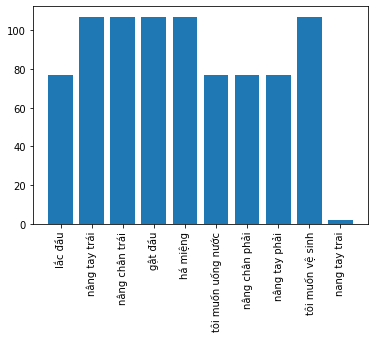

In [4]:
%%time
subjects_scenarios = load_subjects(data_dir)
print(f"found {len(subjects_scenarios)} subjects")

scenario_count = dict()
for _, scenarios in subjects_scenarios:
    for scenario in scenarios:
        if scenario in scenario_count:
            scenario_count[scenario] += 1
        else:
            scenario_count[scenario] = 1

plt.bar(scenario_count.keys(), scenario_count.values())
plt.xticks(rotation='vertical')

In [26]:
subjects, _ = zip(*subjects_scenarios)
subjects = sorted(subjects)
for i in range(0, len(subjects), 5):
    print(subjects[i: i + 5])

['ALS01_t1', 'ALS01_t2', 'ALS02_t1', 'ALS02_t2', 'BN001']
['BN002', 'BN003', 'BN004', 'BN099', 'BN100']
['K001', 'K002', 'K003', 'K004', 'K005']
['K006', 'K007', 'K008', 'K009', 'K010']
['K011', 'K012', 'K013', 'K014', 'K015']
['K016', 'K017', 'K018', 'K019', 'K020']
['K021', 'K022', 'K023', 'K024', 'K025']
['K026', 'K027', 'K028', 'K299', 'K300']
['K301', 'K302', 'K303', 'K304', 'K305']
['K306', 'K307', 'K308', 'K309', 'K310']
['K311', 'K312', 'K313', 'K314', 'K315']
['K316', 'K317', 'K318', 'K319', 'K320']
['K321', 'K322', 'K323', 'K324', 'K325']
['K326', 'K327', 'K328', 'K329', 'K330']
['K331', 'K332', 'K333', 'K334', 'K335']
['K336', 'K337', 'K338', 'K339', 'K340']
['K342', 'K343', 'K344', 'K350', 'K351']
['K352', 'K353', 'K354', 'K355', 'K356']
['K357', 'K358', 'K359', 'K360', 'K361']
['K362', 'K363', 'K364', 'K365', 'K366']
['K367', 'K368', 'K369', 'K370', 'K371']
['K372', 'K373', 'K374', 'K375']


In [34]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    # "F3", "Fz", "F4",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    # "C3", "Cz", "C4",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    # "P3", "Pz", "P4",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    # "nâng chân trái_Thinking": "nâng chân trái",
    # "nâng chân phải_Thinking": "nâng chân phải",
    "nâng chân trái_Thinking": "nâng chân",
    "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "nâng chân trái_Thinking and Acting": "nâng chân",
    "nâng chân phải_Thinking and Acting": "nâng chân",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 32.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


subject:  17%|██████████▋                                                      | 18/109 [00:00<00:01, 45.64it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  26%|████████████████▋                                                | 28/109 [00:00<00:02, 39.98it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited

loaded 96 subjects - 34836 epochs
CPU times: user 51.4 s, sys: 2.99 s, total: 54.3 s
Wall time: 58 s


subject        scenario                event          label  trial  \
0       K001   nâng tay trái             Thinking  nâng tay trái      0   
1       K001   nâng tay trái              Resting           rest      0   
2       K001   nâng tay trái  Thinking and Acting  nâng tay trái      0   
3       K001   nâng tay trái              Resting           rest      1   
4       K001   nâng tay trái             Thinking  nâng tay trái      1   
...      ...             ...                  ...            ...    ...   
3703    K375  nâng chân phải              Resting           rest      3   
3704    K375  nâng chân phải             Thinking      nâng chân      2   
3705    K375  nâng chân phải              Resting           rest      4   
3706    K375  nâng chân phải  Thinking and Acting      nâng chân      2   
3707    K375  nâng chân phải              Resting           rest      5   

      split  epochs  
0     train       9  
1     train      10  
2     train      22  
3     train       5  
4     train      10  
...     ...     ...  
3703  train       5  
3704  train      11  
3705  train       6  
3706  train       9  
3707  train       3  

[3708 rows x 7 columns]

In [29]:
!mkdir -p ./data/vin

In [35]:
with open("./data/vin/LRF0_4classes_32c_action.pkl", mode="wb") as f:
    pkl.dump(ds, f)

<AxesSubplot:>

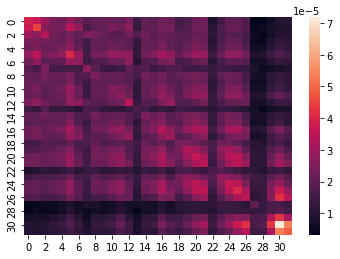

In [36]:
sb.heatmap(np.cov(ds.datasets[0].windows.get_data()[0], rowvar=True))
# sb.distplot(ds.datasets[0].windows.get_data())

In [37]:
euclidean_alignment(ds, target_subject=None, labeled_trials=None)

subject: 100%|██████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 24.74it/s]


In [38]:
with open("./data/vin/LRF0_4classes_32c_action-EA.pkl", mode="wb") as f:
    pkl.dump(ds, f)

<AxesSubplot:>

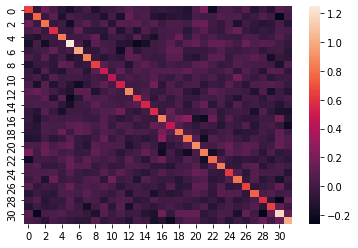

In [39]:
sb.heatmap(np.cov(ds.datasets[0].windows.get_data()[0], rowvar=True))

In [40]:
ds.datasets[0].windows.event_id

{'rest': 0, 'nâng chân': 1, 'nâng tay phải': 2, 'nâng tay trái': 3}

In [36]:
ds.datasets[0].y

[4, 4, 4, 4, 4, 4, 4, 4, 4]

#### Physionet

In [12]:
!mkdir -p data/phy && rm -rf ./data/phy/*
# !cp -r ./drive/MyDrive/beetl/phy_vin_1_40.pkl ./data/phy/
# !cp -r ./drive/MyDrive/beetl/phy_vin_41_80.pkl ./data/phy/
# !cp -r ./drive/MyDrive/beetl/phy_vin_81_109.pkl ./data/phy/
!cp -r ./drive/MyDrive/beetl/phy_vin_1_40_braindcd.pkl ./data/phy/
!cp -r ./drive/MyDrive/beetl/phy_vin_41_80_braindcd.pkl ./data/phy/
!cp -r ./drive/MyDrive/beetl/phy_vin_81_109_braindcd.pkl ./data/phy/

In [ ]:
label_map = {"rest": 0, "feet": 1, "hands": 2, "left_hand": 3, "right_hand": 4}

list_of_ds = list()
for s, e in [(1, 40), (41, 80), (81, 109)]:
    with open(f"./data/phy/phy_vin_{s}_{e}.pkl", mode="rb") as f:
        X, labels, meta = pkl.load(f)["data"]
        meta["label"] = labels

        meta = meta[meta["label"].isin(label_map)]
        X = X[meta.index]
        meta = meta.reset_index(drop=True)
        meta["label_idx"] = 0
        for i, r in meta.iterrows():
            meta.loc[i, "label_idx"] = label_map[r["label"]]

        for subject in meta["subject"].unique():
            subject_meta = meta[meta["subject"] == subject]
            x = X[subject_meta.index]
            y = np.array(subject_meta["label_idx"], dtype=int)
            subject_meta = subject_meta.reset_index(drop=True)

            subject_ds = create_from_X_y(
                x,
                y,
                drop_last_window=True,
                sfreq=128.0,
                ch_names=channels,
                window_size_samples=256,
                window_stride_samples=64,
            )
            for i, ds in enumerate(subject_ds.datasets):
                r = subject_meta.iloc[i]

                setattr(
                    ds,
                    "_description",
                    pd.Series(
                        {
                            "subject": f"PHY_{subject:03d}",
                            "scenario": r["label"],
                            "event": "Resting" if r["label"] == "rest" else "Thinking",
                            "label": r["label"],
                            "trial": int(r["run"].split("_")[1]),
                            "split": "train",
                        }
                    ),
                )

            list_of_ds.append(subject_ds)

phy_ds = BaseConcatDataset(list_of_ds)
phy_ds_info = phy_ds.description

phy_ds_info

In [12]:
list_of_ds = list()
for s, e in [(1, 40), (41, 80), (81, 109)]:
    with open(f"../data/beetl/phy_vin_{s}_{e}_braindcd.pkl", mode="rb") as f:
        ds = pkl.load(f)
        list_of_ds.extend(ds.datasets)

phy_ds = BaseConcatDataset(list_of_ds)
phy_ds_info = phy_ds.description

phy_ds_info["epochs"] = 0
for i, r in phy_ds_info.iterrows():
    phy_ds_info.loc[i, "epochs"] = len(phy_ds.datasets[i].windows)

phy_ds_info

subject    scenario     event       label  trial  split  epochs
0      PHY_001        rest   Resting        rest      0  train       3
1      PHY_001  right_hand  Thinking  right_hand      0  train       3
2      PHY_001        rest   Resting        rest      0  train       3
3      PHY_001   left_hand  Thinking   left_hand      0  train       3
4      PHY_001        rest   Resting        rest      0  train       3
...        ...         ...       ...         ...    ...    ...     ...
18895  PHY_109       hands  Thinking       hands      5  train       3
18896  PHY_109        rest   Resting        rest      5  train       3
18897  PHY_109        feet  Thinking        feet      5  train       3
18898  PHY_109        rest   Resting        rest      5  train       3
18899  PHY_109        feet  Thinking        feet      5  train       3

[18900 rows x 7 columns]

In [13]:
phy_ds_info["label"].unique()

array(['rest', 'right_hand', 'left_hand', 'feet', 'hands'], dtype=object)

## lightning model

In [3]:
from typing import Type, Callable, Dict, Tuple, List, Union, Optional
from itertools import combinations, product
from collections import defaultdict
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time
from datetime import timedelta
import pickle as pkl
import os
import uuid
import random
import math
import numpy as np
from scipy import linalg, stats, signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
# import torch_geometric.nn as gnn
# from torch_geometric.data import Data as GraphData
# from torch_geometric.loader import DataLoader as GraphDataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, StochasticWeightAveraging, EarlyStopping
from pytorch_metric_learning import losses
import sklearn.metrics as metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from braindecode.models import ShallowFBCSPNet, EEGNetv4
from braindecode.models.tidnet import _TIDNetFeatures
# from batchinstancenorm import BatchInstanceNorm2d
# from bcn import BCNorm
# from eadam import EAdam

seed = 42  # @param

pl.seed_everything(seed)

torch.backends.cudnn.benchmark = False

device = torch.device("cuda")

Global seed set to 42


In [4]:
%load_ext tensorboard
%matplotlib inline

#### data loader

In [5]:
class ImbalancedDataSampler(td.Sampler):
    def __init__(self, targets: np.ndarray):  # [len(data),]
        self.num_samples = len(targets)

        count = np.bincount(targets)
        self.weight = torch.tensor(1.0 / count[targets]).float()

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        return (
            int(i)
            for i in torch.multinomial(self.weight, self.num_samples, replacement=True)
        )

In [6]:
class SubjectSampler(td.Sampler):
    def __init__(
        self, subjects: np.ndarray, is_training: bool = True, batch_size: int = 1
    ):  # [len(data),]
        values, counts = np.unique(subjects, return_counts=True)
        counts = counts // batch_size + 1  # num of sampling times
        self.num_samples = counts.sum() * batch_size

        self.indices = {v: np.where(subjects == v)[0] for v in values}

        self.subject_indices = list()
        for i, v in enumerate(values):
            self.subject_indices.extend([v] * counts[i])
        self.subject_indices = np.array(self.subject_indices, dtype=int)

        self.is_training = is_training
        self.batch_size = batch_size

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        if self.is_training:
            np.random.shuffle(self.subject_indices)

            indices = list()
            for v in self.subject_indices:
                indices.extend(
                    np.random.choice(
                        self.indices[v], self.batch_size, replace=True
                    ).tolist()
                )

            return iter(indices)

        else:
            indices = list()
            indices_idx = {k: 0 for k in self.indices.keys()}
            for v in self.subject_indices:
                vi = list()
                while len(vi) < self.batch_size:
                    vi.append(self.indices[v][indices_idx[v]])
                    indices_idx[v] = (indices_idx[v] + 1) % len(self.indices[v])

                indices.extend(vi)

            return iter(indices)

In [1]:
class MultipleLoader(object):
    def __init__(self, list_of_loader: List[td.DataLoader]):
        self.list_of_loader = list_of_loader
        self.list_of_loader_iter = [iter(loader) for loader in list_of_loader]

        self.n_steps = max([len(loader) for loader in list_of_loader])

    def __len__(self):
        return self.n_steps

    def __iter__(self):
        for _ in range(self.n_steps):
            batch = list()
            for i, loader_iter in enumerate(self.list_of_loader_iter):
                try:
                    batch.append(loader_iter.next())

                except StopIteration:
                    self.list_of_loader_iter[i] = iter(self.list_of_loader[i])

                    batch.append(self.list_of_loader_iter[i].next())

            yield batch

NameError: name 'List' is not defined

In [8]:
class EEGDataset(td.Dataset):
    STD_SCALE = 1.0 / 1.4628

    def __init__(
        self,
        X: np.ndarray,
        Y: Optional[np.ndarray] = None,
        is_training: bool = True,
        use_augmentation: bool = True,
        use_normalization: bool = True,
        seed: int = 42,
    ):
        super().__init__()

        assert X.ndim == 3, f"invalid data shape {X.ndim} != 3"

        self.X = X  # [B,C,T]
        self.Y = Y  # [B,]

        self.is_training = is_training
        self.use_augmentation = use_augmentation
        self.use_normalization = use_normalization

        self.rng = np.random.RandomState(seed=seed)

    def __len__(self):
        return len(self.X)

    @property
    def class_weight(self) -> np.ndarray:
        return compute_class_weight("balanced", classes=np.unique(self.Y), y=self.Y)

    def augmentation(self, x):
        if self.rng.uniform() < 0.5:  # gaussian noise
            x += self.rng.normal(
                0.0, 0.2 * np.std(x, axis=-1, keepdims=True), size=x.shape
            )

        return x

    def normalization(self, x):
        mean = np.median(x, axis=-1, keepdims=True)
        std = np.expand_dims(
            stats.median_abs_deviation(x, axis=-1, scale=self.STD_SCALE),
            axis=-1,
        )
        # mean = np.mean(x, axis=-1, keepdims=True)
        # std = np.std(x, axis=-1, keepdims=True)

        x -= mean
        x /= std

        return x

    def __getitem__(self, item):
        x = self.X[item]
        y = self.Y[item] if self.Y is not None else -1

        if self.use_augmentation:
            x = self.augmentation(x)

        if self.use_normalization:
            x = self.normalization(x)

        return x, y

    @staticmethod
    def batchify(batch):
        x, y = zip(*batch)

        x = torch.tensor(np.stack(x)).float()
        y = torch.tensor(np.array(y, dtype=int)).long()

        return x, y


# def get_eeg_data_loader(
#     eeg_data: Union[BaseConcatDataset, Tuple[np.ndarray, Optional[np.ndarray]]],
#     is_training: bool = True,
#     use_augmentation: bool = True,
#     use_normalization: bool = True,
#     seed: int = 42,
#     batch_size: int = 1,
#     num_samples: Optional[int] = None,
#     use_imbalanced_sampler: bool = False,
#     **kwargs,
# ) -> Tuple[td.Dataset, td.DataLoader]:
#     if isinstance(eeg_data, BaseConcatDataset):
#         X = list()
#         Y = list()
#         for ds in eeg_data.datasets:
#             X.append(ds.windows.get_data())
#             Y.extend(ds.y)

#         X = np.concatenate(X, axis=0)
#         Y = np.array(Y, dtype=int)

#     else:
#         X, Y = eeg_data

#     eeg_ds = EEGDataset(
#         X,
#         Y,
#         is_training=is_training,
#         use_augmentation=use_augmentation,
#         use_normalization=use_normalization,
#         seed=seed,
#     )

#     sampler = None
#     if num_samples is not None:
#         sampler = td.RandomSampler(eeg_ds, replacement=True, num_samples=num_samples)
#     elif use_imbalanced_sampler:
#         sampler = ImbalancedDataSampler(eeg_ds.Y)

#     loader = td.DataLoader(
#         eeg_ds,
#         batch_size=batch_size,
#         shuffle=is_training and sampler is None,
#         sampler=sampler,
#         num_workers=kwargs.pop("num_workers", os.cpu_count()),
#         collate_fn=EEGDataset.batchify,
#         pin_memory=True,
#         **kwargs,
#     )

#     return eeg_ds, loader


def get_eeg_data_loader(
    eeg_data: Union[
        BaseConcatDataset, Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]
    ],
    is_training: bool = True,
    use_augmentation: bool = True,
    use_normalization: bool = True,
    seed: int = 42,
    batch_size: int = 1,
    num_samples: Optional[int] = None,
    use_imbalanced_sampler: bool = False,
    use_subject_sampler: bool = False,
    **kwargs,
) -> Tuple[td.Dataset, td.DataLoader]:
    if isinstance(eeg_data, BaseConcatDataset):
        X = list()
        Y = list()
        S = list()
        for ds in eeg_data.datasets:
            x = ds.windows.get_data()
            X.append(x)
            Y.extend(ds.y)
            S.extend([ds.description["subject"]] * len(x))

        X = np.concatenate(X, axis=0)
        Y = np.array(Y, dtype=int)
        S = LabelEncoder().fit_transform(S)

    else:
        X, Y, S = eeg_data

    if use_subject_sampler and S is not None:
        idx = np.argsort(S)
        X = X[idx]
        Y = Y[idx]
        S = S[idx]

    eeg_ds = EEGDataset(
        X,
        Y,
        is_training=is_training,
        use_augmentation=use_augmentation,
        use_normalization=use_normalization,
        seed=seed,
    )

    sampler = None
    if num_samples is not None:
        sampler = td.RandomSampler(eeg_ds, replacement=True, num_samples=num_samples)
    elif use_imbalanced_sampler:
        sampler = ImbalancedDataSampler(eeg_ds.Y)
    elif use_subject_sampler and S is not None:
        sampler = SubjectSampler(S, is_training=is_training, batch_size=batch_size)

    loader = td.DataLoader(
        eeg_ds,
        batch_size=batch_size,
        shuffle=is_training and sampler is None,
        sampler=sampler,
        num_workers=kwargs.pop("num_workers", os.cpu_count()),
        collate_fn=EEGDataset.batchify,
        pin_memory=True,
        **kwargs,
    )

    return eeg_ds, loader

In [9]:
# class GraphEEGDataset(td.Dataset):
#     STD_SCALE = 1.0 / 1.4628

#     def __init__(
#         self,
#         X: np.ndarray,
#         Y: Optional[np.ndarray] = None,
#         top_k: Optional[int] = None,
#         is_training: bool = True,
#         use_augmentation: bool = True,
#         use_normalization: bool = True,
#         seed: int = 42,
#     ):
#         super().__init__()

#         assert X.ndim == 3, f"invalid data shape {X.ndim} != 3"

#         self.X = X  # [B,C,T]
#         self.Y = Y  # [B,]

#         # TODO: implement topk edges
#         self.top_k = (
#             (top_k + 1) if top_k is not None else None
#         )  # ignore self-connection

#         self.n_channels = X.shape[1]

#         self.is_training = is_training
#         self.use_augmentation = use_augmentation
#         self.use_normalization = use_normalization

#         self.rng = np.random.RandomState(seed=seed)

#     def __len__(self):
#         return len(self.X)

#     @property
#     def class_weight(self) -> np.ndarray:
#         return compute_class_weight("balanced", classes=np.unique(self.Y), y=self.Y)

#     def augmentation(self, x):
#         if self.rng.uniform() < 0.5:  # gaussian noise
#             x += self.rng.normal(
#                 0.0, 0.2 * np.std(x, axis=-1, keepdims=True), size=x.shape
#             )

#         return x

#     def normalization(self, x):
#         mean = np.median(x, axis=-1, keepdims=True)
#         std = np.expand_dims(
#             stats.median_abs_deviation(x, axis=-1, scale=self.STD_SCALE),
#             axis=-1,
#         )
#         # mean = np.mean(x, axis=-1, keepdims=True)
#         # std = np.std(x, axis=-1, keepdims=True)

#         x -= mean
#         x /= std

#         return x

#     def compute_edge_weight(self, x):  # w >= 0
#         # pearson correlation coefficients
#         x = x - x.mean(axis=-1, keepdims=True)
#         x = (x @ np.swapaxes(x, -1, -2)) / (x.shape[-1] - 1)  # [B,C,C]

#         diag = np.expand_dims(np.diagonal(x, axis1=-1, axis2=-2), axis=-1)  # [B,C,1]
#         x /= np.sqrt(diag @ np.swapaxes(diag, -1, -2))  # [B,C,C] \in [-1, 1]
#         x /= 2.0
#         x += 0.5

#         return x

#     def __getitem__(self, item):
#         x = self.X[item]
#         y = self.Y[item] if self.Y is not None else -1

#         if self.use_augmentation:
#             x = self.augmentation(x)

#         # if self.use_normalization:
#         x = self.normalization(x)

#         edge_weight = self.compute_edge_weight(x)  # [C,C]
#         if self.top_k is not None:
#             indices = edge_weight.argsort(axis=1)[:, -self.top_k :]
#             edge_index = set()
#             for i, j in product(range(self.n_channels), range(self.top_k)):
#                 if (i, indices[i, j]) in edge_index:
#                     continue
#                 edge_index.add((i, indices[i, j]))
#                 if indices[i, j] != i:
#                     edge_index.add((indices[i, j], i))
#             edge_index = np.array(list(edge_index), dtype=int).T
#             edge_weight = edge_weight[edge_index[0], edge_index[1]]  # [nE]

#         else:
#             # without self-connection
#             # edge_index = np.array(
#             #     list(combinations(range(self.n_channels), r=2)), dtype=int
#             # )
#             # edge_index = np.hstack((edge_index, edge_index[:, ::-1])).T  # [2,nE]
#             # with self-connection
#             edge_index = np.array(
#                 list(product(range(self.n_channels), range(self.n_channels))), dtype=int
#             ).T  # [2,nE]
#             edge_weight = edge_weight[edge_index[0], edge_index[1]]  # [nE,]

#         return GraphData(
#             x=torch.tensor(x).float(),
#             edge_index=torch.tensor(edge_index).long(),
#             y=torch.tensor([y]).long(),
#             edge_weight=torch.tensor(edge_weight).float(),
#         )


# def get_graph_eeg_data_loader(
#     eeg_data: Union[BaseConcatDataset, Tuple[np.ndarray, Optional[np.ndarray]]],
#     top_k: Optional[int] = None,
#     is_training: bool = True,
#     use_augmentation: bool = True,
#     use_normalization: bool = True,
#     seed: int = 42,
#     batch_size: int = 1,
#     num_samples: Optional[int] = None,
#     use_imbalanced_sampler: bool = False,
#     **kwargs,
# ) -> Tuple[td.Dataset, td.DataLoader]:
#     if isinstance(eeg_data, BaseConcatDataset):
#         X = list()
#         Y = list()
#         for ds in eeg_data.datasets:
#             X.append(ds.windows.get_data())
#             Y.extend(ds.y)

#         X = np.concatenate(X, axis=0)
#         Y = np.array(Y, dtype=int)

#     else:
#         X, Y = eeg_data

#     eeg_ds = GraphEEGDataset(
#         X,
#         Y,
#         top_k=top_k,
#         is_training=is_training,
#         use_augmentation=use_augmentation,
#         use_normalization=use_normalization,
#         seed=seed,
#     )

#     sampler = None
#     if num_samples is not None:
#         sampler = td.RandomSampler(eeg_ds, replacement=True, num_samples=num_samples)
#     elif use_imbalanced_sampler:
#         sampler = ImbalancedDataSampler(eeg_ds.Y)

#     loader = GraphDataLoader(
#         eeg_ds,
#         batch_size=batch_size,
#         shuffle=is_training and sampler is None,
#         sampler=sampler,
#         num_workers=kwargs.pop("num_workers", os.cpu_count()),
#         pin_memory=True,
#         **kwargs,
#     )

#     return eeg_ds, loader

#### losses

In [10]:
def nll_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    smooth: float = 0,
    reduce: bool = True,
) -> torch.Tensor:
    # input (log_prob): [bsz, num_classes], target (classes): [bsz]
    n_classes = input.size(1)
    target0 = F.one_hot(target, num_classes=n_classes).float()
    target = (1.0 - smooth) * target0 + smooth / n_classes

    if weight is not None:
        if reduce:
            return -(target * weight * input).sum() / (target0 * weight).sum()

        return -(target * weight * input).sum(dim=1)

    else:
        if reduce:
            return -(target * input).sum(dim=1).mean()

        return -(target * input).sum(dim=1)


def focal_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    smooth: float = 0,
    gamma: float = 2.0,
    reduce: bool = True,
) -> torch.Tensor:
    # https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
    # not working well with smooth

    # input (log_prob): [bsz, num_classes], target (classes): [bsz]
    n_classes = input.size(1)
    sm_gamma = F.one_hot(target, num_classes=n_classes).float() * gamma  # disable (1-p)^g on negative indices
    weighted_input = torch.pow(1.0 - torch.exp(input), sm_gamma) * input

    return nll_loss(weighted_input, target, weight=weight, smooth=smooth, reduce=reduce)


class NllLoss(nn.Module):
    def __init__(
        self,
        weight: Optional[torch.Tensor] = None,
        smooth: float = 0,
        reduce: bool = True,
    ):
        super().__init__()

        self.register_buffer(
            "weight", weight.unsqueeze(0) if weight is not None else None
        )  # [1, n_classes]
        self.weight: Optional[torch.Tensor]

        self.smooth = smooth
        self.reduce = reduce

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return nll_loss(
            input,
            target,
            weight=self.weight,
            smooth=self.smooth,
            reduce=self.reduce,
        )


class FocalLoss(NllLoss):
    """
    class-weighted focal loss
    """

    def __init__(
        self,
        weight: Optional[torch.Tensor] = None,
        smooth: float = 0,
        gamma: float = 2.0,
        reduce: bool = True,
    ):
        super().__init__(weight, smooth, reduce)

        self.gamma = gamma

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(
            input,
            target,
            weight=self.weight,
            smooth=self.smooth,
            gamma=self.gamma,
            reduce=self.reduce,
        )

#### models

In [11]:
class DynamicSpatialBlock(nn.Module):
    """
    Dynamic spatial filtering (n_in_channels -> n_out_channels)
    https://arxiv.org/abs/2105.12916

    # TODO: check working with normalized EEG?
    """

    def __init__(self, n_in_channels, n_out_channels, logcov=True, soft_thresh=0.1, drop_prob=0.25):
        super().__init__()

        inp = (n_in_channels * (n_in_channels + 1) // 2) if logcov else n_in_channels
        out = n_out_channels * n_in_channels + n_out_channels
        hid = out // 4

        self.linear = nn.Sequential(
            nn.Linear(inp, hid, bias=True),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=drop_prob),
            nn.Linear(hid, out, bias=True),
            # LinearWithConstraint(hid, out, max_norm=1.0, bias=True),
        )

        self.inds = torch.triu_indices(
            n_in_channels, n_in_channels
        )  # upper, [2,n_in*(n_in+1)/2]

        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.logcov = logcov
        self.soft_thresh = soft_thresh

    def forward(self, x):  # x: [B,C,T]
        # x is not NORMALIZED

        if self.logcov:
            # compute log-covariance
            # log(C) = Ulog(V)U.T
            xm = x - x.mean(dim=2, keepdim=True)
            cov = torch.matmul(xm, xm.transpose(2, 1)) / (xm.size(2) - 1)

            e, v = torch.linalg.eigh(cov, UPLO="U")
            e = torch.log(torch.clamp(e, min=1e-10))
            log_cov = torch.matmul(
                torch.matmul(v, e.diag_embed()), v.transpose(2, 1)
            )  # [B,C,C]

            feats = log_cov[:, self.inds[0], self.inds[1]]  # [B,n_in*(n_in+1)/2]

        else:
            # compute log-variance
            feats = torch.log(torch.var(x, dim=2, unbiased=True))
            feats[torch.isneginf(feats)] = 0

        feats = self.linear(feats)  # [B,n_out*n_in+n_out]

        w = feats[:, : -self.n_out_channels].reshape(
            -1, self.n_out_channels, self.n_in_channels
        )  # [B,n_out,n_in]
        b = feats[:, -self.n_out_channels :].reshape(
            -1, self.n_out_channels, 1
        )  # [B,n_out,1]

        if self.logcov and self.soft_thresh > 0:
            # apply soft-thresholding in [-thr,thr]
            w = torch.clamp(w - self.soft_thresh, min=0) + torch.clamp(
                w + self.soft_thresh, max=0
            )

        x = (x - x.mean(dim=2, keepdim=True)) / x.std(dim=2, keepdim=True)
        x = torch.matmul(w, x) + b

        return x

In [12]:
class WSConv2d(nn.Conv2d):
    def __init__(self, *args, max_norm: Optional[float] = None, **kwargs):
        self.max_norm = max_norm
        super(WSConv2d, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        std, mean = torch.std_mean(self.weight.data, dim=(1, 2, 3), keepdim=True)
        self.weight.data = (self.weight.data - mean) / (std + 1e-5)
        # self.weight.data = self.weight.data - mean

        if self.max_norm is not None:
            self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        
        return super(WSConv2d, self).forward(x)


class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm: float = 1.0, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(Conv2dWithConstraint, self).forward(x)


class LinearWithConstraint(nn.Linear):
    def __init__(self, *args, max_norm: float = 1.0, **kwargs):
        self.max_norm = max_norm
        super(LinearWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(LinearWithConstraint, self).forward(x)


class TemporalNorm(nn.Module):
    def __init__(self, in_chans, F1):
        super().__init__()

        # self.norm = BCNorm(
        #     in_chans * F1, num_groups=in_chans, momentum=0.01, estimate=True
        # )
        # self.norm = nn.BatchNorm2d(in_chans * F1, momentum=0.01, affine=True, eps=1e-3)
        self.norm = nn.GroupNorm(num_groups=in_chans, num_channels=in_chans * F1)
        # self.norm = nn.InstanceNorm2d(in_chans * F1, momentum=0.01, affine=True, eps=1e-3)
        
        # self.norm = nn.GroupNorm(num_groups=in_chans, num_channels=in_chans)
        
        self.in_chans = in_chans
        self.F1 = F1

    def forward(self, x):  # [B,F1,C,T]
        x = (
            x.permute(0, 2, 1, 3)
            .reshape(x.size(0), self.in_chans * self.F1, 1, -1)
            .contiguous()
        )
        x = self.norm(x)
        x = (
            x.reshape(x.size(0), self.in_chans, self.F1, -1)
            .permute(0, 2, 1, 3)
            .contiguous()
        )
        
        # x = x.permute(0, 2, 1, 3).contiguous()
        # x = self.norm(x)
        # x = x.permute(0, 2, 1, 3).contiguous()

        return x


class ConvTS(nn.Sequential):
    def __init__(
        self,
        in_chans,
        in_depth,
        F1=8,
        D=2,
        kernel_length=64,
        pool_mode="mean",
        drop_prob=0.25,
    ):
        super().__init__()

        pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[pool_mode]

        assert F1 % 8 == 0
        
        self.add_module(
            "conv_temporal",
            # nn.Conv2d(
            WSConv2d(
                in_depth,
                F1,
                kernel_size=(1, kernel_length),
                stride=(1, 1),
                padding=(0, kernel_length // 2),
                bias=False,
            ),
        )
        self.add_module(
            "bnorm_temporal",
            # nn.BatchNorm2d(F1, momentum=0.01, affine=True, eps=1e-3),
            # nn.InstanceNorm2d(F1, momentum=0.01, affine=True, eps=1e-3),
            # nn.GroupNorm(num_groups=8, num_channels=F1),
            # BatchInstanceNorm2d(F1, momentum=0.01, affine=True, eps=1e-3),
            # BCNorm(F1, num_groups=8, momentum=0.01, eps=1e-5, estimate=True),
            TemporalNorm(in_chans, F1),
        )
        self.add_module(
            "conv_spatial",
            # Conv2dWithConstraint(
            WSConv2d(
                F1,
                F1 * D,
                max_norm=1.0,
                kernel_size=(in_chans, 1),
                stride=(1, 1),
                padding=(0, 0),
                groups=F1,
                bias=False,
            ),
        )
        self.add_module(
            "bnorm_1",
            # nn.BatchNorm2d(F1 * D, momentum=0.01, affine=True, eps=1e-3),
            # nn.InstanceNorm2d(F1 * D, momentum=0.01, affine=True, eps=1e-3),
            nn.GroupNorm(num_groups=8, num_channels=F1 * D),
            # BatchInstanceNorm2d(F1 * D, momentum=0.01, affine=True, eps=1e-3),
            # BCNorm(F1 * D, num_groups=8, momentum=0.01, eps=1e-5, estimate=True),
        )
        # self.add_module("elu_1", nn.ELU(inplace=True))
        self.add_module("elu_1", nn.Mish())
        self.add_module("pool_1", pool_class(kernel_size=(1, 4), stride=(1, 4)))
        self.add_module("drop_1", nn.Dropout(p=drop_prob))


class MB_EEGNet(nn.Module):
    def __init__(
        self,
        n_classes,
        in_chans,
        in_samples,
        in_depth=1,
        final_conv_length="auto",
        pool_mode="mean",
        F1=8,
        D=2,
        F2=16,
        F3=16,
        kernel_lengths=(64,),
        third_kernel_size=(8, 4),
        drop_prob=0.5,
    ):
        super().__init__()

        pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[pool_mode]

        self.conv_1s = nn.ModuleList()
        for kernel_length in kernel_lengths:
            self.conv_1s.append(
                ConvTS(
                    in_chans,
                    in_depth,
                    F1,
                    D,
                    kernel_length,
                    pool_mode,
                    drop_prob,
                )
            )

        self.conv_2 = nn.Sequential()
        self.conv_2.add_module(
            "conv_separable_depth",
            nn.Conv2d(
                F1 * D * len(kernel_lengths),
                F1 * D * len(kernel_lengths),
                kernel_size=(1, 16),
                stride=(1, 1),
                padding=(0, 8),
                groups=F1 * D * len(kernel_lengths),
                bias=False,
            ),
        )
        self.conv_2.add_module(
            "conv_separable_point",
            # nn.Conv2d(
            WSConv2d(
                F1 * D * len(kernel_lengths),
                F2,
                kernel_size=(1, 1),
                stride=(1, 1),
                padding=(0, 0),
                bias=False,
            ),
        )
        self.conv_2.add_module(
            "bnorm_2",
            # nn.BatchNorm2d(F2, momentum=0.01, affine=True, eps=1e-3),
            # nn.InstanceNorm2d(F2, momentum=0.01, affine=True, eps=1e-3),
            nn.GroupNorm(num_groups=8, num_channels=F2),
            # BatchInstanceNorm2d(F2, momentum=0.01, affine=True, eps=1e-3),
            # BCNorm(F2, num_groups=8, momentum=0.01, eps=1e-5, estimate=True),
        )
        # self.conv_2.add_module("elu_2", nn.ELU(inplace=True))
        self.conv_2.add_module("elu_2", nn.Mish())
        self.conv_2.add_module("pool_2", pool_class(kernel_size=(1, 8), stride=(1, 8)))
        self.conv_2.add_module("drop_2", nn.Dropout(p=drop_prob))

        # with torch.no_grad():
        #     x = torch.zeros((1, in_depth, in_chans, in_samples), dtype=torch.float32)
        #     x = torch.stack([conv(x) for conv in self.conv_1s]).sum(dim=0)
        #     x = self.conv_2(x)
        #     x = x.cpu().data.numpy()

        self.conv_3 = nn.Sequential()
        self.conv_3.add_module(
            "conv_separable_depth",
            nn.Conv2d(
                F2,
                F2,
                # kernel_size=(x.shape[2], x.shape[3]),
                kernel_size=(1, 4),
                stride=(1, 1),
                # padding=(0, 0),
                padding=(0, 2),
                groups=F2,
                bias=False,
            ),
        )
        self.conv_3.add_module(
            "conv_separable_point",
            # nn.Conv2d(
            WSConv2d(
                F2,
                F3,
                kernel_size=(1, 1),
                stride=(1, 1),
                padding=(0, 0),
                bias=False,
            ),
        )
        self.conv_3.add_module(
            "bnorm_3",
            # nn.BatchNorm2d(F3, momentum=0.01, affine=True, eps=1e-3),
            # nn.InstanceNorm2d(F3, momentum=0.01, affine=True, eps=1e-3),
            nn.GroupNorm(num_groups=8, num_channels=F3),
            # BatchInstanceNorm2d(F3, momentum=0.01, affine=True, eps=1e-3),
            # BCNorm(F3, num_groups=8, momentum=0.01, eps=1e-5, estimate=True),
        )
        # self.conv_3.add_module("elu_3", nn.ELU(inplace=True))
        self.conv_3.add_module("elu_3", nn.Mish())
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        # self.drop = nn.Dropout(p=drop_prob)
        # self.clf = nn.Linear(F3, n_classes, bias=True)

    def forward(self, x: torch.Tensor):
        if x.ndim == 3:
            x = x.unsqueeze(1)  # [B1CT]

        x = torch.cat([conv(x) for conv in self.conv_1s], dim=1)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)  # [B,F3]
        # x = self.drop(x)
        # x = self.clf(x)

        return x
    
    
class MB_EEGRnn(nn.Module):
    def __init__(
        self,
        n_classes,
        in_chans,
        in_samples,
        in_depth=1,
        pool_mode="mean",
        F1=8,
        D=2,
        F2=16,
        num_layers=1,
        kernel_lengths=(64,),
        drop_prob=0.5,
    ):
        super().__init__()

        self.conv_1s = nn.ModuleList()
        for kernel_length in kernel_lengths:
            self.conv_1s.append(
                ConvTS(
                    in_chans,
                    in_depth,
                    F1,
                    D,
                    kernel_length,
                    pool_mode,
                    drop_prob,
                )
            )

        self.gru = nn.GRU(
            F1 * D * len(kernel_lengths),
            F2,
            num_layers=num_layers,
            bias=True,
            batch_first=False,
            dropout=drop_prob,
            bidirectional=True,
        )

    def forward(self, x):  # x: [B,C,T]
        if x.ndim == 3:
            x = x.unsqueeze(1)  # x: [B,1,C,T]

        x = torch.cat([conv(x) for conv in self.conv_1s], dim=1)  # x: [B,F1*D,1,T//*]
        x = x.squeeze(2)

        x = x.permute(2, 0, 1)  # [L,B,F1*D*Ks]
        x, h = self.gru(x)  # x: [L,B,F2*2], h: [2*n_layers,B,F2]

        # attention
        # get forward/backward of last layer's hidden
        h = torch.cat((h[-2], h[-1]), dim=1)  # [B,F2*2]
        h = h.unsqueeze(2)

        x = x.permute(1, 0, 2)
        a = torch.matmul(x, h)  # a: [B,L,1]
        a = F.softmax(a, dim=1)

        x = x * a  # x: [B,L,F2*2]
        x = x.sum(dim=1)  # [B,F2*2]

        return x


class EEGClassifier(nn.Module):
    def __init__(self, F3, n_classes, drop_prob=0.5):
        super().__init__()

        self.drop = nn.Dropout(p=drop_prob)
        self.ln = nn.Linear(F3, n_classes, bias=True)
        # self.ln = LinearWithConstraint(F3, n_classes, max_norm=0.5, bias=True)

    def forward(self, x):
        x = self.drop(x)
        x = self.ln(x)

        return x

In [13]:
# class ConvT(nn.Sequential):
#     def __init__(
#         self,
#         in_chans,
#         F1=8,
#         kernel_length=32,
#         pool_mode="mean",
#         drop_prob=0.5,
#     ):
#         super().__init__()

#         pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[pool_mode]

#         self.add_module(
#             "conv_dw",
#             nn.Conv2d(
#                 in_chans,
#                 in_chans,
#                 kernel_size=(1, kernel_length),
#                 stride=(1, 1),
#                 padding=(0, kernel_length // 2),
#                 groups=in_chans,
#                 bias=False,
#             ),
#         )
#         self.add_module(
#             "conv_pw",
#             nn.Conv2d(
#                 in_chans,
#                 in_chans * F1,
#                 kernel_size=(1, 1),
#                 stride=(1, 1),
#                 padding=(0, 0),
#                 groups=in_chans,
#                 bias=False,
#             ),
#         )
#         self.add_module("bnorm", nn.BatchNorm2d(in_chans * F1))
#         self.add_module("elu", nn.ELU(inplace=True))
#         self.add_module("pool", pool_class(kernel_size=(1, 4), stride=(1, 4)))
#         self.add_module("drop", nn.Dropout(p=drop_prob))


# class MB_EEGNet_GNN(nn.Module):
#     def __init__(
#         self,
#         n_classes,
#         in_chans,
#         in_samples,
#         in_depth=1,
#         final_conv_length="auto",
#         pool_mode="mean",
#         F1=8,
#         D=2,
#         F2=16,
#         F3=16,
#         kernel_lengths=(32,),
#         third_kernel_size=(8, 4),
#         drop_prob=0.5,
#     ):
#         super().__init__()

#         pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[pool_mode]

#         # CNN
#         self.conv_1s = nn.ModuleList()
#         for kernel_length in kernel_lengths:
#             self.conv_1s.append(
#                 ConvT(
#                     in_chans,
#                     F1,
#                     kernel_length,
#                     pool_mode,
#                     drop_prob,
#                 )
#             )

#         self.conv_2 = nn.Sequential()
#         self.conv_2.add_module(
#             "conv_dw",
#             nn.Conv2d(
#                 in_chans * F1,
#                 in_chans * F1,
#                 kernel_size=(1, 16),
#                 stride=(1, 1),
#                 padding=(0, 8),
#                 groups=in_chans * F1,
#                 bias=False,
#             ),
#         )
#         self.conv_2.add_module(
#             "conv_pw",
#             nn.Conv2d(
#                 in_chans * F1,
#                 in_chans * F2,
#                 kernel_size=(1, 1),
#                 stride=(1, 1),
#                 padding=(0, 0),
#                 groups=in_chans,
#                 bias=False,
#             ),
#         )
#         self.conv_2.add_module("bnorm", nn.BatchNorm2d(in_chans * F2))
#         self.conv_2.add_module("elu", nn.ELU(inplace=True))
#         self.conv_2.add_module("pool", pool_class(kernel_size=(1, 8), stride=(1, 8)))
#         self.conv_2.add_module("drop", nn.Dropout(p=drop_prob))

#         with torch.no_grad():
#             x = torch.zeros((1, in_chans, 1, in_samples), dtype=torch.float32)
#             x = torch.stack([conv(x) for conv in self.conv_1s]).sum(dim=0)
#             x = self.conv_2(x)
#             x = x.cpu().data.numpy()

#         self.conv_3 = nn.Sequential()
#         self.conv_3.add_module(
#             "conv_dw",
#             nn.Conv2d(
#                 in_chans * F2,
#                 in_chans * F2,
#                 kernel_size=(1, x.shape[3]),
#                 stride=(1, 1),
#                 padding=(0, 0),
#                 groups=in_chans * F2,
#                 bias=False,
#             ),
#         )
#         self.conv_3.add_module(
#             "conv_pw",
#             nn.Conv2d(
#                 in_chans * F2,
#                 in_chans * F3,
#                 kernel_size=(1, 1),
#                 stride=(1, 1),
#                 padding=(0, 0),
#                 groups=in_chans,
#                 bias=False,
#             ),
#         )
#         self.conv_3.add_module("bnorm", nn.BatchNorm2d(in_chans * F3))
#         self.conv_3.add_module("elu", nn.ELU(inplace=True))

#         # Classifier
#         # self.clf = nn.Linear(F3, n_classes, bias=True)

#         self.in_chans = in_chans
#         self.in_samples = in_samples
#         self.F3 = F3

#     def forward(self, x):
#         """
#         x: [B*C,T]
#         """
#         x = x.reshape(-1, self.in_chans, 1, self.in_samples).contiguous()
#         x = torch.stack(([conv(x) for conv in self.conv_1s])).sum(dim=0)
#         x = self.conv_2(x)
#         x = self.conv_3(x)  # [B,C*F3,1,1]
#         x = x.reshape(-1, self.in_chans, self.F3).reshape(-1, self.F3).contiguous()

#         # Classifier
#         # x = self.clf(x)

#         return x


# class GraphEEGClassifier(nn.Module):
#     def __init__(self, F3, n_classes, drop_prob=0.5):
#         super().__init__()

#         # GCN
#         self.gconv_1 = gnn.Sequential(
#             "x, edge_index, edge_weight",
#             [
#                 (nn.Dropout(p=drop_prob), "x -> x"),
#                 (
#                     gnn.GCNConv(
#                         F3, F3, add_self_loops=False, normalize=True, bias=False
#                     ),
#                     "x, edge_index, edge_weight -> x",
#                     # gnn.GATv2Conv(
#                     #     F3,
#                     #     F3,
#                     #     heads=1,
#                     #     dropout=0.0,
#                     #     add_self_loops=False,
#                     #     bias=False,
#                     # ),
#                     # "x, edge_index -> x",
#                 ),
#                 nn.BatchNorm1d(F3),
#                 nn.ELU(inplace=True),
#             ],
#         )

#         self.gconv_2 = gnn.Sequential(
#             "x, edge_index, edge_weight",
#             [
#                 (nn.Dropout(p=drop_prob), "x -> x"),
#                 (
#                     gnn.GCNConv(
#                         F3, F3, add_self_loops=False, normalize=True, bias=False
#                     ),
#                     "x, edge_index, edge_weight -> x",
#                     # gnn.GATv2Conv(
#                     #     F3,
#                     #     F3,
#                     #     heads=1,
#                     #     dropout=0.0,
#                     #     add_self_loops=False,
#                     #     bias=False,
#                     # ),
#                     # "x, edge_index -> x",
#                 ),
#                 nn.BatchNorm1d(F3),
#                 nn.ELU(inplace=True),
#             ],
#         )

#         # Classifier
#         self.drop = nn.Dropout(p=drop_prob)

#         self.ln = nn.Linear(F3, n_classes, bias=True)

#     def forward(self, x, edge_index, edge_weight, batch):
#         # GCN
#         x = self.gconv_1(x, edge_index, edge_weight)
#         x = self.gconv_2(x, edge_index, edge_weight)
#         x = gnn.global_mean_pool(x, batch)  # [B,F3]

#         # Classifier
#         x = self.drop(x)
#         x = self.ln(x)

#         return x

#### lightning model

In [14]:
# mish initialization
def init_weights_for_mish(m, variance=1.0):

    def _calculate_fan_in_and_fan_out(tensor):
        dimensions = tensor.dim()
        if dimensions < 2:
            return 1, 1

        if dimensions == 2:  # Linear
            fan_in = tensor.size(1)
            fan_out = tensor.size(0)
        else:
            num_input_fmaps = tensor.size(1)
            num_output_fmaps = tensor.size(0)
            receptive_field_size = 1
            if tensor.dim() > 2:
                receptive_field_size = tensor[0][0].numel()
            fan_in = num_input_fmaps * receptive_field_size
            fan_out = num_output_fmaps * receptive_field_size

        return fan_in, fan_out

    def _initialize_weights(tensor, variance, filters=1):
        fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
        gain = variance / math.sqrt(fan_in * filters)
        with torch.no_grad():
            torch.nn.init.normal_(tensor)
            return tensor.data * gain

    def _initialize_bias(tensor, variance):
        with torch.no_grad():
            torch.nn.init.normal_(tensor)
            return tensor.data * variance

    if m is None:
        return
    if hasattr(m, 'weight') and m.weight is not None:
        # We want to avoid initializing Batch Normalization
        if hasattr(m, 'running_mean'):
            return

        # If we have channels we probably are a Convolutional Layer
        filters = 1
        if hasattr(m, 'in_channels'):
            filters = m.in_channels

        m.weight.data = _initialize_weights(m.weight, variance=variance, filters=filters)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data = _initialize_bias(m.bias, variance=variance)

In [15]:
def init_weights(module: nn.Module, xavier_init: bool = True, gain: float = 1.0, nonlinearity: str = "leaky_relu"):
    for m in module.modules():
        if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
            if xavier_init:
                nn.init.xavier_uniform_(m.weight, gain=gain)
                # nn.init.xavier_normal_(m.weight, gain=gain)
            else:
                nn.init.kaiming_uniform_(m.weight, nonlinearity=nonlinearity)
                # nn.init.kaiming_normal_(m.weight, nonlinearity=nonlinearity)

            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.0)

            # init_weights_for_mish(m)
        
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, val=1.0)
            nn.init.constant_(m.bias, val=0.0)


def static_batchnorm(module: nn.Module):
    # https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/110362
    for m in module.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.track_running_stats = False
            m.affine = False


def confusion_matrix_figure(y_true, y_pred) -> Figure:
        cfm = metrics.confusion_matrix(y_true, y_pred, normalize="true")
        cfm = np.round(cfm, 4)

        fig = plt.figure()
        plt.imshow(cfm, cmap=plt.cm.Blues)
        for i in range(cfm.shape[0]):
            for j in range(cfm.shape[1]):
                plt.text(i, j, cfm[j, i], va="center", ha="center")

        return fig


def compute_scores(y_true, y_pred) -> Dict[str, float]:
    scores = {
        "acc": metrics.balanced_accuracy_score(y_true, y_pred),
        # "pre": metrics.precision_score(y_true, y_pred, average="weighted"),
        # "rec": metrics.recall_score(y_true, y_pred, average="weighted"),
        "f1": metrics.f1_score(y_true, y_pred, average="weighted"),
        "kappa": metrics.cohen_kappa_score(y_true, y_pred),
    }

    return scores

In [24]:
class MotorImageryModule(pl.LightningModule):
    def __init__(self, n_classes, n_channels, n_samples, **kwargs):
        super().__init__()

        self.save_hyperparameters()

        self.n_channels = n_channels
        self.n_samples = n_samples

        #####################################
        ##              CNN                ##
        #####################################

        self.base_model = MB_EEGNet(
            n_classes=n_classes,
            in_chans=n_channels,
            in_samples=n_samples,
            in_depth=1,
            final_conv_length="auto",
            pool_mode="mean",
            F1=8,
            D=4,
            F2=32,
            F3=64,
            kernel_lengths=(64,),
            third_kernel_size=(8, 4),
            drop_prob=self.hparams.get("drop_prob", 0.0),
        )
        # self.base_model = MB_EEGRnn(
        #     n_classes=n_classes,
        #     in_chans=n_channels,
        #     in_samples=n_samples,
        #     in_depth=1,
        #     pool_mode="max",
        #     F1=8,
        #     D=4,
        #     F2=32,
        #     num_layers=1,
        #     kernel_lengths=(64,),
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        # )
        # self.base_model = _TIDNetFeatures(
        #     s_growth=8,
        #     t_filters=8,
        #     in_chans=n_channels,
        #     input_window_samples=n_samples,
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        #     pooling=32,
        #     temp_layers=2,
        #     spat_layers=2,
        #     temp_span=0.125,
        #     bottleneck=2,
        #     summary=-1,
        # )
        self.clf = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        
        #####################################
        ##              GNN                ##
        #####################################

        # self.base_model = MB_EEGNet_GNN(
        #     n_classes=n_classes,
        #     in_chans=n_channels,
        #     in_samples=n_samples,
        #     in_depth=1,
        #     final_conv_length="auto",
        #     pool_mode="mean",
        #     F1=8,
        #     D=2,
        #     F2=16,
        #     F3=16,
        #     kernel_lengths=(32,),
        #     third_kernel_size=(8, 4),
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        # )
        # self.clf = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        init_weights(self.base_model, xavier_init=True, gain=1.0, nonlinearity="leaky_relu")  # elu's alpha=1.0
        init_weights(self.clf, xavier_init=True, gain=1.0, nonlinearity="leaky_relu")

        # loss' params
        self.class_weight = self.hparams.get("class_weight", None)
        self.smooth_label = self.hparams.get("smooth_label", 0.0)

        # mixup
        self.mixup_alpha = self.hparams.get("mixup_alpha", 0.0)
        self.rng = np.random.RandomState(seed=self.hparams.get("rng_seed", 42))

        # manual optimization
        # https://pytorch-lightning.readthedocs.io/en/stable/common/optimizers.html
        # self.automatic_optimization = False

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        if self.hparams.get("use_lr_sch", False):
            optimizer_dict = {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.get("epochs", 1)),
                    # "scheduler": optim.lr_scheduler.MultiStepLR(optimizer, milestones=[self.hparams.get("after_n_epochs", 1000)], gamma=0.1),
                    "name": "optim/lr",
                },
            }

        else:
            optimizer_dict = {
                "optimizer": optimizer,
            }

        return optimizer_dict

    def compute_loss(self, x, y, class_weight=None, reduce=True):
        x = F.log_softmax(x, dim=1)

        return nll_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)
        # return focal_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)

    def forward(self, x):
        #####################################
        ##              CNN                ##
        #####################################

        x = self.base_model(x)
        x = self.clf(x)

        return x

        #####################################
        ##              GNN                ##
        #####################################

        # x0 = self.base_model(x[0])
        # x0 = self.clf(x0, *x[1:])

        # return x0

    def predict(self, x):
        return torch.argmax(F.log_softmax(self(x), dim=1), dim=1)

    def epoch_end(self, outputs, mode="train"):
        y_true = torch.cat([output["y_true"] for output in outputs], dim=0).detach().cpu().numpy()
        y_pred = torch.cat([output["y_pred"] for output in outputs], dim=0).detach().cpu().numpy()

        # plot confusion matrix
        fig = self.logger.experiment.add_figure(f"{mode}/confusion_matrix", confusion_matrix_figure(y_true=y_true, y_pred=y_pred))

        # plot metrics
        scores = compute_scores(y_true=y_true, y_pred=y_pred)
        if mode != "train":
            scores["loss"] = float(torch.stack([output["loss"] for output in outputs]).mean())

        for k, v in scores.items():
            self.log(f"{mode}/{k}", v)

    def shared_step(self, x, y, class_weight=None, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################
            
            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()
            y_perm = y[perm]

            x = lam * x + _1_lam * x[perm]

            x = self(x)

            loss = lam * self.compute_loss(x, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x, y_perm, class_weight, reduce=False)
            loss = loss.mean()

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()
            # y_perm = y[perm]

            # x0 = lam * x0 + _1_lam * x0[perm]
            # x0 = x0.reshape(-1, self.n_samples)

            # x0 = self((x0, *x[1:]))

            # loss = lam * self.compute_loss(x0, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x0, y_perm, class_weight, reduce=False)
            # loss = loss.mean()

        else:
            x = self(x)

            loss = self.compute_loss(x, y, class_weight)

        return loss

    def training_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        x, y = batch  # X*: [B,C,T], Y*: [B,]

        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################
        
        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        loss = self.shared_step(x, y, self.class_weight, self.mixup_alpha)
        self.log("train/loss", loss)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="train")

    def validation_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        x, y = batch  # X*: [B,C,T], Y*: [B,]

        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        loss = self.shared_step(x, y, self.class_weight)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="valid")

    def test_step(self, batch, batch_idx, **kwargs):
        return self.validation_step(batch, batch_idx, **kwargs)

    def test_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="test")

In [17]:
class MultiDatasetsMotorImageryModule(pl.LightningModule):  # support 2 datasets only?
    def __init__(self, n_classes, n_channels, n_samples, n_src_classes, **kwargs):
        super().__init__()

        self.save_hyperparameters()

        self.n_channels = n_channels
        self.n_samples = n_samples

        #####################################
        ##              CNN                ##
        #####################################

        self.base_model = MB_EEGNet(
            n_classes=n_classes,
            in_chans=n_channels,
            in_samples=n_samples,
            in_depth=1,
            final_conv_length="auto",
            pool_mode="mean",
            F1=8,
            D=4,
            F2=32,
            F3=64,
            kernel_lengths=(64,),
            third_kernel_size=(8, 4),
            drop_prob=self.hparams.get("drop_prob", 0.0),
        )
        self.clf = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        self.src_clf = EEGClassifier(64, n_src_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        
        #####################################
        ##              GNN                ##
        #####################################

        # self.base_model = MB_EEGNet_GNN(
        #     n_classes=n_classes,
        #     in_chans=n_channels,
        #     in_samples=n_samples,
        #     in_depth=1,
        #     final_conv_length="auto",
        #     pool_mode="mean",
        #     F1=8,
        #     D=2,
        #     F2=16,
        #     F3=16,
        #     kernel_lengths=(32,),
        #     third_kernel_size=(8, 4),
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        # )
        # self.clf = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        init_weights(self.base_model, xavier_init=True, gain=1.0)  # elu's alpha=1.0
        init_weights(self.clf, xavier_init=True, gain=1.0)
        init_weights(self.src_clf, xavier_init=True, gain=1.0)

        # loss' params
        self.src_class_weight = self.hparams.get("src_class_weight", None)
        self.tgt_class_weight = self.hparams.get("tgt_class_weight", None)
        self.smooth_label = self.hparams.get("smooth_label", 0.0)

        self.src_loss_scale = self.hparams.get("src_loss_scale", 1.0)
        self.tgt_loss_scale = self.hparams.get("tgt_loss_scale", 1.0)
        self.after_n_epochs = self.hparams.get("after_n_epochs", 1000)

        # mixup
        self.src_mixup_alpha = self.hparams.get("src_mixup_alpha", 0.0)
        self.tgt_mixup_alpha = self.hparams.get("tgt_mixup_alpha", 0.0)
        self.rng = np.random.RandomState(seed=self.hparams.get("rng_seed", 42))

        # manual optimization
        # https://pytorch-lightning.readthedocs.io/en/stable/common/optimizers.html
        # self.automatic_optimization = False

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        if self.hparams.get("use_lr_sch", False):
            optimizer_dict = {
                "optimizer": optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr",
                },
            }

        else:
            optimizer_dict = {
                "optimizer": optimizer,
            }

        return optimizer_dict

    def compute_loss(self, x, y, class_weight=None, reduce=True):
        x = F.log_softmax(x, dim=1)

        # return nll_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)
        return focal_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)

    def forward(self, x):
        #####################################
        ##              CNN                ##
        #####################################

        x = self.base_model(x)
        x = self.clf(x)

        return x

        #####################################
        ##              GNN                ##
        #####################################

        # x0 = self.base_model(x[0])
        # x0 = self.clf(x0, *x[1:])

        # return x0

    def predict(self, x):
        return torch.argmax(F.log_softmax(self(x), dim=1), dim=1)

    def epoch_end(self, outputs, mode="train"):
        y_true = torch.cat([output["y_true"] for output in outputs], dim=0).detach().cpu().numpy()
        y_pred = torch.cat([output["y_pred"] for output in outputs], dim=0).detach().cpu().numpy()

        # plot confusion matrix
        fig = self.logger.experiment.add_figure(f"{mode}/confusion_matrix", confusion_matrix_figure(y_true=y_true, y_pred=y_pred))

        # plot metrics
        scores = compute_scores(y_true=y_true, y_pred=y_pred)
        if mode != "train":
            scores["loss"] = float(torch.stack([output["loss"] for output in outputs]).mean())

        for k, v in scores.items():
            self.log(f"{mode}/{k}", v)

    def shared_step(self, x, y, clf, class_weight=None, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################
            
            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()
            y_perm = y[perm]

            x = lam * x + _1_lam * x[perm]

            # x = self(x)
            x = clf(self.base_model(x))

            loss = lam * self.compute_loss(x, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x, y_perm, class_weight, reduce=False)
            loss = loss.mean()

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()
            # y_perm = y[perm]

            # x0 = lam * x0 + _1_lam * x0[perm]
            # x0 = x0.reshape(-1, self.n_samples)

            # x0 = self((x0, *x[1:]))
            # x0 = clf(self.base_model(x0), *x[1:])

            # loss = lam * self.compute_loss(x0, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x0, y_perm, class_weight, reduce=False)
            # loss = loss.mean()

        else:
            # x = self(x)
            x = clf(self.base_model(x))

            loss = self.compute_loss(x, y, class_weight)

        return loss

    def training_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        (xsrc, ysrc), (x, y) = batch  # X*: [B,C,T], Y*: [B,]

        xsrc = xsrc.to(self.device)
        ysrc = ysrc.to(self.device)
        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################
        
        # batch_src, batch = batch

        # xsrc = (batch_src.x.to(self.device), batch_src.edge_index.to(self.device), batch_src.edge_weight.to(self.device), batch_src.batch.to(self.device))
        # ysrc = batch_src.y.to(self.device)
        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        # loss = self.shared_step(x, y, self.class_weight, self.mixup_alpha)
        loss = self.src_loss_scale * self.shared_step(xsrc, ysrc, self.src_clf, self.src_class_weight, self.src_mixup_alpha) + self.tgt_loss_scale * self.shared_step(x, y, self.clf, self.tgt_class_weight, self.tgt_mixup_alpha)

        self.log("train/loss", loss)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def on_train_epoch_start(self):
        if self.current_epoch >= self.after_n_epochs:
            self.src_loss_scale = self.hparams.get("src_loss_scale_after_n", self.src_loss_scale)
            self.tgt_loss_scale = self.hparams.get("tgt_loss_scale_after_n", self.tgt_loss_scale)

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="train")

    def validation_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        x, y = batch  # X*: [B,C,T], Y*: [B,]

        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        loss = self.shared_step(x, y, self.clf, self.tgt_class_weight)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="valid")

    def test_step(self, batch, batch_idx, **kwargs):
        return self.validation_step(batch, batch_idx, **kwargs)

    def test_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="test")

In [18]:
class MCDMotorImageryModule(pl.LightningModule):
    def __init__(self, n_classes, n_channels, n_samples, **kwargs):
        super().__init__()

        self.save_hyperparameters()

        self.n_channels = n_channels
        self.n_samples = n_samples

        #####################################
        ##              CNN                ##
        #####################################

        self.base_model = MB_EEGNet(
            n_classes=n_classes,
            in_chans=n_channels,
            in_samples=n_samples,
            in_depth=1,
            final_conv_length="auto",
            pool_mode="mean",
            F1=8,
            D=4,
            F2=32,
            F3=64,
            kernel_lengths=(64,),
            third_kernel_size=(8, 4),
            drop_prob=self.hparams.get("drop_prob", 0.0),
        )
        self.clf1 = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        self.clf2 = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        
        #####################################
        ##              GNN                ##
        #####################################

        # self.base_model = MB_EEGNet_GNN(
        #     n_classes=n_classes,
        #     in_chans=n_channels,
        #     in_samples=n_samples,
        #     in_depth=1,
        #     final_conv_length="auto",
        #     pool_mode="mean",
        #     F1=8,
        #     D=2,
        #     F2=16,
        #     F3=16,
        #     kernel_lengths=(32,),
        #     third_kernel_size=(8, 4),
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        # )
        # self.clf1 = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        # self.clf2 = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        init_weights(self.base_model, xavier_init=True, gain=1.0)  # elu's alpha=1.0
        init_weights(self.clf1, xavier_init=True, gain=1.0)
        init_weights(self.clf2, xavier_init=True, gain=1.0)
        # init_weights(self.clf2, xavier_init=False, nonlinearity="leaky_relu")

        # loss' params
        self.src_class_weight = self.hparams.get("src_class_weight", None)
        self.tgt_class_weight = self.hparams.get("tgt_class_weight", None)
        self.smooth_label = self.hparams.get("smooth_label", 0.0)

        self.src_loss_scale = self.hparams.get("src_loss_scale", 1.0)
        self.tgt_loss_scale = self.hparams.get("tgt_loss_scale", 1.0)
        self.after_n_epochs = self.hparams.get("after_n_epochs", 1000)

        # mixup
        self.src_mixup_alpha = self.hparams.get("src_mixup_alpha", 0.0)
        self.tgt_mixup_alpha = self.hparams.get("tgt_mixup_alpha", 0.0)
        self.rng = np.random.RandomState(seed=self.hparams.get("rng_seed", 42))

        # manual optimization
        # https://pytorch-lightning.readthedocs.io/en/stable/common/optimizers.html
        self.automatic_optimization = False

        self.mcd_step_C_steps = self.hparams.get("mcd_step_C_steps", 1)

    def configure_optimizers(self):
        # base model's optimizer
        base_model_optimizer = optim.AdamW(
            self.base_model.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        # classifiers' optimizer
        clf1_optimizer = optim.AdamW(
            self.clf1.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        clf2_optimizer = optim.AdamW(
            self.clf2.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        if self.hparams.get("use_lr_sch", False):
            optimizer_dict = {
                "optimizer": base_model_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(base_model_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(base_model_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_base_model",
                },
            }

            clf1_optimizer_dict = {
                "optimizer": clf1_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(clf1_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(clf1_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_clf1",
                },
            }

            clf2_optimizer_dict = {
                "optimizer": clf2_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(clf2_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(clf2_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_clf2",
                },
            }

        else:
            optimizer_dict = {
                "optimizer": base_model_optimizer,
            }

            clf1_optimizer_dict = {
                "optimizer": clf1_optimizer,
            }

            clf2_optimizer_dict = {
                "optimizer": clf2_optimizer,
            }

        return [optimizer_dict, clf1_optimizer_dict, clf2_optimizer_dict]

    def compute_loss(self, x, y, class_weight=None, reduce=True):
        x = F.log_softmax(x, dim=1)

        # return nll_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)
        return focal_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)

    def compute_discrepancy_loss(self, x1, x2):
        x1 = F.softmax(x1, dim=1)
        x2 = F.softmax(x2, dim=1)

        return torch.abs(x1 - x2).mean()

    def forward(self, x):
        #####################################
        ##              CNN                ##
        #####################################

        x = self.base_model(x)
        x1 = self.clf1(x)
        x2 = self.clf2(x)

        return x1, x2

        #####################################
        ##              GNN                ##
        #####################################

        # x0 = self.base_model(x[0])
        # x1 = self.clf1(x0, *x[1:])
        # x2 = self.clf2(x0, *x[1:])

        # return x1, x2

    def predict(self, x):
        x1, x2 = self(x)

        return torch.argmax(F.log_softmax(x1 + x2, dim=1), dim=1)

    def epoch_end(self, outputs, mode="train"):
        y_true = torch.cat([output["y_true"] for output in outputs], dim=0).detach().cpu().numpy()
        y_pred = torch.cat([output["y_pred"] for output in outputs], dim=0).detach().cpu().numpy()

        # plot confusion matrix
        fig = self.logger.experiment.add_figure(f"{mode}/confusion_matrix", confusion_matrix_figure(y_true=y_true, y_pred=y_pred))

        # plot metrics
        scores = compute_scores(y_true=y_true, y_pred=y_pred)
        if mode != "train":
            scores["loss"] = float(torch.stack([output["loss"] for output in outputs]).mean())

        for k, v in scores.items():
            self.log(f"{mode}/{k}", v)

    def shared_step(self, x, y, class_weight=None, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################
            
            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()
            y_perm = y[perm]

            x = lam * x + _1_lam * x[perm]

            x1, x2 = self(x)

            loss1 = lam * self.compute_loss(x1, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x1, y_perm, class_weight, reduce=False)
            loss2 = lam * self.compute_loss(x2, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x2, y_perm, class_weight, reduce=False)

            loss = loss1.mean() + loss2.mean()

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()
            # y_perm = y[perm]

            # x0 = lam * x0 + _1_lam * x0[perm]
            # x0 = x0.reshape(-1, self.n_samples)

            # x1, x2 = self((x0, *x[1:]))

            # loss1 = lam * self.compute_loss(x1, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x1, y_perm, class_weight, reduce=False)
            # loss2 = lam * self.compute_loss(x2, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x2, y_perm, class_weight, reduce=False)

            # loss = loss1.mean() + loss2.mean()

        else:
            x1, x2 = self(x)

            loss = self.compute_loss(x1, y, class_weight) + self.compute_loss(x2, y, class_weight)

        return loss

    def shared_discrepancy_step(self, x, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################

            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()

            x = lam * x + _1_lam * x[perm]

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()

            # x0 = lam * x0 + _1_lam * x0[perm]

            # x = (x0, *x[1:])

        x1, x2 = self(x)

        loss = self.compute_discrepancy_loss(x1, x2)

        return loss
        
    def training_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        # (xsrc, ysrc), (xtgt, ytgt), (xtgt_unlabeled, _) = batch  # X*: [B,C,T], Y*: [B,]

        # xsrc = xsrc.to(self.device)
        # ysrc = ysrc.to(self.device)
        # xtgt = xtgt.to(self.device)
        # ytgt = ytgt.to(self.device)
        # xtgt_unlabeled = xtgt_unlabeled.to(self.device)

        (xsrc, ysrc), (xtgt_unlabeled, _) = batch  # X*: [B,C,T], Y*: [B,]

        xsrc = xsrc.to(self.device)
        ysrc = ysrc.to(self.device)
        xtgt_unlabeled = xtgt_unlabeled.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # dsrc, dtgt, dtgt_unlabeled = batch  # graph's data
        
        # xsrc = (dsrc.x.to(self.device), dsrc.edge_index.to(self.device), dsrc.edge_weight.to(self.device), dsrc.batch.to(self.device))
        # ysrc = dsrc.y.to(self.device)
        # xtgt = (dtgt.x.to(self.device), dtgt.edge_index.to(self.device), dtgt.edge_weight.to(self.device), dtgt.batch.to(self.device))
        # ytgt = dtgt.y.to(self.device)
        # xtgt_unlabeled = (dtgt_unlabeled.x.to(self.device), dtgt_unlabeled.edge_index.to(self.device), dtgt_unlabeled.edge_weight.to(self.device), dtgt_unlabeled.batch.to(self.device))

        # y_pred = self.predict(xtgt)
        y_pred = self.predict(xsrc)

        base_model_optimizer, clf1_optimizer, clf2_optimizer = self.optimizers()

        # step A: training on sources and labeled target data
        # loss_step_A = self.src_loss_scale * self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha) + self.tgt_loss_scale * self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha)
        loss_step_A = self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha)
        self.log("train/loss_step_A", loss_step_A)

        base_model_optimizer.zero_grad()
        clf1_optimizer.zero_grad()
        clf2_optimizer.zero_grad()

        self.manual_backward(loss_step_A)

        base_model_optimizer.step()
        clf1_optimizer.step()
        clf2_optimizer.step()

        # step B: training (classifiers) on labeled target data and maximize classifiers' discrepancy
        # loss_step_B = self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled, self.tgt_mixup_alpha)
        # loss_step_B = self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled)
        loss_step_B = self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled)
        self.log("train/loss_step_B", loss_step_B)

        base_model_optimizer.zero_grad()
        clf1_optimizer.zero_grad()
        clf2_optimizer.zero_grad()

        self.manual_backward(loss_step_B)

        clf1_optimizer.step()
        clf2_optimizer.step()

        # step C: training (base model) to minimize classifiers' discrepancy
        loss_step_C = 0
        for _ in range(self.mcd_step_C_steps):
            # loss_step_Ci = self.shared_discrepancy_step(xtgt_unlabeled, self.tgt_mixup_alpha)
            loss_step_Ci = self.shared_discrepancy_step(xtgt_unlabeled)

            base_model_optimizer.zero_grad()
            clf1_optimizer.zero_grad()
            clf2_optimizer.zero_grad()

            self.manual_backward(loss_step_Ci)

            base_model_optimizer.step()

            loss_step_C += loss_step_Ci

        loss_step_C /= self.mcd_step_C_steps
        self.log("train/loss_step_C", loss_step_C)

        return {
            # "y_true": ytgt,
            "y_true": ysrc,
            "y_pred": y_pred,
        }

    def on_train_epoch_start(self):
        if self.current_epoch >= self.after_n_epochs:
            self.src_loss_scale = self.hparams.get("src_loss_scale_after_n", self.src_loss_scale)
            self.tgt_loss_scale = self.hparams.get("tgt_loss_scale_after_n", self.tgt_loss_scale)

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="train")

        lr_sch = self.lr_schedulers()
        if lr_sch is not None:
            if isinstance(lr_sch, list):
                for sch in lr_sch:
                    sch.step()
            else:
                lr_sch.step()

    def validation_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        loss = self.shared_step(x, y, self.tgt_class_weight, mixup_alpha=0)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="valid")

    def test_step(self, batch, batch_idx, **kwargs):
        return self.validation_step(batch, batch_idx, **kwargs)

    def test_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="test")

In [19]:
class MultiDatasetsMCDMotorImageryModule(pl.LightningModule):  # support 2 datasets only?
    def __init__(self, n_classes, n_channels, n_samples, n_src_classes, **kwargs):
        super().__init__()

        self.save_hyperparameters()

        self.n_channels = n_channels
        self.n_samples = n_samples

        #####################################
        ##              CNN                ##
        #####################################

        self.base_model = MB_EEGNet(
            n_classes=n_classes,
            in_chans=n_channels,
            in_samples=n_samples,
            in_depth=1,
            final_conv_length="auto",
            pool_mode="mean",
            F1=8,
            D=4,
            F2=32,
            F3=64,
            kernel_lengths=(64,),
            third_kernel_size=(8, 4),
            drop_prob=self.hparams.get("drop_prob", 0.0),
        )
        self.clf1 = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        self.clf2 = EEGClassifier(64, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        self.src_clf = EEGClassifier(64, n_src_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        
        #####################################
        ##              GNN                ##
        #####################################

        # self.base_model = MB_EEGNet_GNN(
        #     n_classes=n_classes,
        #     in_chans=n_channels,
        #     in_samples=n_samples,
        #     in_depth=1,
        #     final_conv_length="auto",
        #     pool_mode="mean",
        #     F1=8,
        #     D=2,
        #     F2=16,
        #     F3=16,
        #     kernel_lengths=(32,),
        #     third_kernel_size=(8, 4),
        #     drop_prob=self.hparams.get("drop_prob", 0.0),
        # )
        # self.clf1 = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))
        # self.clf2 = GraphEEGClassifier(16, n_classes, drop_prob=self.hparams.get("drop_prob", 0.0))

        init_weights(self.base_model, xavier_init=True, gain=1.0)  # elu's alpha=1.0
        init_weights(self.clf1, xavier_init=True, gain=1.0)
        init_weights(self.clf2, xavier_init=True, gain=1.0)
        # init_weights(self.clf2, xavier_init=False, nonlinearity="leaky_relu")

        init_weights(self.src_clf, xavier_init=True, gain=1.0)

        # loss' params
        self.src_class_weight = self.hparams.get("src_class_weight", None)
        self.tgt_class_weight = self.hparams.get("tgt_class_weight", None)
        self.smooth_label = self.hparams.get("smooth_label", 0.0)

        self.src_loss_scale = self.hparams.get("src_loss_scale", 1.0)
        self.tgt_loss_scale = self.hparams.get("tgt_loss_scale", 1.0)
        self.after_n_epochs = self.hparams.get("after_n_epochs", 1000)

        # mixup
        self.src_mixup_alpha = self.hparams.get("src_mixup_alpha", 0.0)
        self.tgt_mixup_alpha = self.hparams.get("tgt_mixup_alpha", 0.0)
        self.rng = np.random.RandomState(seed=self.hparams.get("rng_seed", 42))

        # manual optimization
        # https://pytorch-lightning.readthedocs.io/en/stable/common/optimizers.html
        self.automatic_optimization = False

        self.mcd_step_C_steps = self.hparams.get("mcd_step_C_steps", 1)

    def configure_optimizers(self):
        # base model's optimizer
        base_model_optimizer = optim.AdamW(
            self.base_model.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        # classifiers' optimizer
        clf1_optimizer = optim.AdamW(
            self.clf1.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        clf2_optimizer = optim.AdamW(
            self.clf2.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        src_clf_optimizer = optim.AdamW(
            self.src_clf.parameters(),
            lr=self.hparams.get("lr", 1e-3),
            weight_decay=self.hparams.get("weight_decay", 0.0),
            amsgrad=False,
        )

        if self.hparams.get("use_lr_sch", False):
            optimizer_dict = {
                "optimizer": base_model_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(base_model_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(base_model_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_base_model",
                },
            }

            clf1_optimizer_dict = {
                "optimizer": clf1_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(clf1_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(clf1_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_clf1",
                },
            }

            clf2_optimizer_dict = {
                "optimizer": clf2_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(clf2_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(clf2_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_clf2",
                },
            }

            src_clf_optimizer_dict = {
                "optimizer": src_clf_optimizer,
                "lr_scheduler": {
                    # "scheduler": optim.lr_scheduler.CosineAnnealingLR(clf2_optimizer, T_max=self.hparams.get("epochs", 1)),
                    "scheduler": optim.lr_scheduler.MultiStepLR(clf2_optimizer, milestones=[self.after_n_epochs], gamma=0.1),
                    "name": "optim/lr_src_clf",
                },
            }

        else:
            optimizer_dict = {
                "optimizer": base_model_optimizer,
            }

            clf1_optimizer_dict = {
                "optimizer": clf1_optimizer,
            }

            clf2_optimizer_dict = {
                "optimizer": clf2_optimizer,
            }

            src_clf_optimizer_dict = {
                "optimizer": src_clf_optimizer,
            }

        return [optimizer_dict, clf1_optimizer_dict, clf2_optimizer_dict, src_clf_optimizer_dict]

    def compute_loss(self, x, y, class_weight=None, reduce=True):
        x = F.log_softmax(x, dim=1)

        # return nll_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)
        return focal_loss(x, y, weight=class_weight, smooth=self.smooth_label, reduce=reduce)

    def compute_discrepancy_loss(self, x1, x2):
        x1 = F.softmax(x1, dim=1)
        x2 = F.softmax(x2, dim=1)

        return torch.abs(x1 - x2).mean()

    def forward(self, x):
        #####################################
        ##              CNN                ##
        #####################################

        x = self.base_model(x)
        x1 = self.clf1(x)
        x2 = self.clf2(x)

        return x1, x2

        #####################################
        ##              GNN                ##
        #####################################

        # x0 = self.base_model(x[0])
        # x1 = self.clf1(x0, *x[1:])
        # x2 = self.clf2(x0, *x[1:])

        # return x1, x2

    def predict(self, x):
        x1, x2 = self(x)

        return torch.argmax(F.log_softmax(x1 + x2, dim=1), dim=1)

    def epoch_end(self, outputs, mode="train"):
        y_true = torch.cat([output["y_true"] for output in outputs], dim=0).detach().cpu().numpy()
        y_pred = torch.cat([output["y_pred"] for output in outputs], dim=0).detach().cpu().numpy()

        # plot confusion matrix
        fig = self.logger.experiment.add_figure(f"{mode}/confusion_matrix", confusion_matrix_figure(y_true=y_true, y_pred=y_pred))

        # plot metrics
        scores = compute_scores(y_true=y_true, y_pred=y_pred)
        if mode != "train":
            scores["loss"] = float(torch.stack([output["loss"] for output in outputs]).mean())

        for k, v in scores.items():
            self.log(f"{mode}/{k}", v)

    def src_step(self, x, y, class_weight=None, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################
            
            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()
            y_perm = y[perm]

            x = lam * x + _1_lam * x[perm]

            x = self.src_clf(self.base_model(x))

            loss = lam * self.compute_loss(x, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x, y_perm, class_weight, reduce=False)
            loss = loss.mean()

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()
            # y_perm = y[perm]

            # x0 = lam * x0 + _1_lam * x0[perm]
            # x0 = x0.reshape(-1, self.n_samples)

            # x = self.src_clf((self.base_model(x0), *x[1:]))

            # loss = lam * self.compute_loss(x, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x, y_perm, class_weight, reduce=False)
            # loss = loss.mean()

        else:
            #####################################
            ##              CNN                ##
            #####################################
            
            x = self.src_clf(self.base_model(x))

            loss = self.compute_loss(x, y, class_weight)

            #####################################
            ##              GNN                ##
            #####################################

            # x = self.src_clf((self.base_model(x[0]), *x[1:]))

            # loss = self.compute_loss(x, y, class_weight)

        return loss

    def shared_step(self, x, y, class_weight=None, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################
            
            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()
            y_perm = y[perm]

            x = lam * x + _1_lam * x[perm]

            x1, x2 = self(x)

            loss1 = lam * self.compute_loss(x1, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x1, y_perm, class_weight, reduce=False)
            loss2 = lam * self.compute_loss(x2, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x2, y_perm, class_weight, reduce=False)

            loss = loss1.mean() + loss2.mean()

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()
            # y_perm = y[perm]

            # x0 = lam * x0 + _1_lam * x0[perm]
            # x0 = x0.reshape(-1, self.n_samples)

            # x1, x2 = self((x0, *x[1:]))

            # loss1 = lam * self.compute_loss(x1, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x1, y_perm, class_weight, reduce=False)
            # loss2 = lam * self.compute_loss(x2, y, class_weight, reduce=False) + _1_lam * self.compute_loss(x2, y_perm, class_weight, reduce=False)

            # loss = loss1.mean() + loss2.mean()

        else:
            x1, x2 = self(x)

            loss = self.compute_loss(x1, y, class_weight) + self.compute_loss(x2, y, class_weight)

        return loss

    def shared_discrepancy_step(self, x, mixup_alpha=0.0):
        if mixup_alpha > 0:
            #####################################
            ##              CNN                ##
            #####################################

            lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x.size(0))).float().to(self.device)
            lam = lam.reshape(-1, 1, 1)
            _1_lam = 1.0 - lam

            perm = torch.tensor(self.rng.permutation(x.size(0))).long()

            x = lam * x + _1_lam * x[perm]

            #####################################
            ##              GNN                ##
            #####################################

            # x0 = x[0]
            # x0 = x0.reshape(-1, self.n_channels, self.n_samples)  # [B,C,T]

            # lam = torch.tensor(self.rng.beta(mixup_alpha, mixup_alpha, x0.size(0))).float().to(self.device)
            # lam = lam.reshape(-1, 1, 1)
            # _1_lam = 1.0 - lam

            # perm = torch.tensor(self.rng.permutation(x0.size(0))).long()

            # x0 = lam * x0 + _1_lam * x0[perm]

            # x = (x0, *x[1:])

        x1, x2 = self(x)

        loss = self.compute_discrepancy_loss(x1, x2)

        return loss
        
    def training_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        (xsrc, ysrc), (xtgt, ytgt), (xtgt_unlabeled, _) = batch  # X*: [B,C,T], Y*: [B,]

        xsrc = xsrc.to(self.device)
        ysrc = ysrc.to(self.device)
        xtgt = xtgt.to(self.device)
        ytgt = ytgt.to(self.device)
        xtgt_unlabeled = xtgt_unlabeled.to(self.device)

        # (xsrc, ysrc), (xtgt_unlabeled, _) = batch  # X*: [B,C,T], Y*: [B,]

        # xsrc = xsrc.to(self.device)
        # ysrc = ysrc.to(self.device)
        # xtgt_unlabeled = xtgt_unlabeled.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # dsrc, dtgt, dtgt_unlabeled = batch  # graph's data
        
        # xsrc = (dsrc.x.to(self.device), dsrc.edge_index.to(self.device), dsrc.edge_weight.to(self.device), dsrc.batch.to(self.device))
        # ysrc = dsrc.y.to(self.device)
        # xtgt = (dtgt.x.to(self.device), dtgt.edge_index.to(self.device), dtgt.edge_weight.to(self.device), dtgt.batch.to(self.device))
        # ytgt = dtgt.y.to(self.device)
        # xtgt_unlabeled = (dtgt_unlabeled.x.to(self.device), dtgt_unlabeled.edge_index.to(self.device), dtgt_unlabeled.edge_weight.to(self.device), dtgt_unlabeled.batch.to(self.device))

        y_pred = self.predict(xtgt)

        base_model_optimizer, clf1_optimizer, clf2_optimizer, src_clf_optimizer = self.optimizers()

        # step A: training on sources and labeled target data
        # loss_step_A = self.src_loss_scale * self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha) + self.tgt_loss_scale * self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha)
        # loss_step_A = self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha)
        loss_step_A = self.src_loss_scale * self.src_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha) + self.tgt_loss_scale * self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha)
        self.log("train/loss_step_A", loss_step_A)

        base_model_optimizer.zero_grad()
        clf1_optimizer.zero_grad()
        clf2_optimizer.zero_grad()
        src_clf_optimizer.zero_grad()

        self.manual_backward(loss_step_A)

        base_model_optimizer.step()
        clf1_optimizer.step()
        clf2_optimizer.step()
        src_clf_optimizer.step()

        # step B: training (classifiers) on labeled target data and maximize classifiers' discrepancy
        # loss_step_B = self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled, self.tgt_mixup_alpha)
        loss_step_B = self.shared_step(xtgt, ytgt, self.tgt_class_weight, self.tgt_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled)
        # loss_step_B = self.shared_step(xsrc, ysrc, self.src_class_weight, self.src_mixup_alpha) - self.shared_discrepancy_step(xtgt_unlabeled)
        self.log("train/loss_step_B", loss_step_B)

        base_model_optimizer.zero_grad()
        clf1_optimizer.zero_grad()
        clf2_optimizer.zero_grad()

        self.manual_backward(loss_step_B)

        clf1_optimizer.step()
        clf2_optimizer.step()

        # step C: training (base model) to minimize classifiers' discrepancy
        loss_step_C = 0
        for _ in range(self.mcd_step_C_steps):
            # loss_step_Ci = self.shared_discrepancy_step(xtgt_unlabeled, self.tgt_mixup_alpha)
            loss_step_Ci = self.shared_discrepancy_step(xtgt_unlabeled)

            base_model_optimizer.zero_grad()
            clf1_optimizer.zero_grad()
            clf2_optimizer.zero_grad()

            self.manual_backward(loss_step_Ci)

            base_model_optimizer.step()

            loss_step_C += loss_step_Ci

        loss_step_C /= self.mcd_step_C_steps
        self.log("train/loss_step_C", loss_step_C)

        return {
            "y_true": ytgt,
            "y_pred": y_pred,
        }

    def on_train_epoch_start(self):
        if self.current_epoch >= self.after_n_epochs:
            self.src_loss_scale = self.hparams.get("src_loss_scale_after_n", self.src_loss_scale)
            self.tgt_loss_scale = self.hparams.get("tgt_loss_scale_after_n", self.tgt_loss_scale)

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="train")

        lr_sch = self.lr_schedulers()
        if lr_sch is not None:
            if isinstance(lr_sch, list):
                for sch in lr_sch:
                    sch.step()
            else:
                lr_sch.step()

    def validation_step(self, batch, batch_idx, **kwargs):
        #####################################
        ##              CNN                ##
        #####################################

        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)

        #####################################
        ##              GNN                ##
        #####################################

        # x = (batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_weight.to(self.device), batch.batch.to(self.device))
        # y = batch.y.to(self.device)

        y_pred = self.predict(x)

        loss = self.shared_step(x, y, self.tgt_class_weight, mixup_alpha=0)

        return {
            "loss": loss,
            "y_true": y,
            "y_pred": y_pred,
        }

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="valid")

    def test_step(self, batch, batch_idx, **kwargs):
        return self.validation_step(batch, batch_idx, **kwargs)

    def test_epoch_end(self, outputs):
        self.epoch_end(outputs, mode="test")

#### training

In [20]:
def do_training(
    exp: str,
    n_classes: int,
    n_channels: int,
    n_samples: int,
    train_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    valid_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    test_data: Optional[List[Tuple[str, Union[BaseConcatDataset, Tuple[np.ndarray, ...]]]]] = None,
    top_k: Optional[int] = None,
    use_augmentation: bool = True,
    use_normalization: bool = True,
    epochs: int = 1,
    batch_size: int = 1,
    lr: float = 1e-3,
    use_lr_sch: bool = True,
    weight_decay: float = 0.0,
    smooth_label: float = 0.0,
    after_n_epochs: int = 1000,
    mixup_alpha: float = 0.0,
    use_class_weight: bool = False,
    use_imbalanced_sampler: bool = False,
    use_subject_sampler: bool = False,
    drop_prob: float = 0.0,
    monitor_val: str = "acc",
    monitor_max_is_best: bool = True,
    patience_epochs: int = 10,
):
    # init data
    train_ds, train_ds_loader = get_eeg_data_loader(
    # train_ds, train_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=use_imbalanced_sampler,
        use_subject_sampler=use_subject_sampler,
    )

    _, valid_ds_loader = get_eeg_data_loader(
    # _, valid_ds_loader = get_graph_eeg_data_loader(
        eeg_data=valid_data,
        # top_k=top_k,
        is_training=False, 
        use_augmentation=False, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=False,
        use_subject_sampler=use_subject_sampler,
    )

    list_of_test_ds_loader = list()
    if test_data is not None:
        for name, _test_data in test_data:
            _, test_ds_loader = get_eeg_data_loader(
            # _, test_ds_loader = get_graph_eeg_data_loader(
                eeg_data=_test_data,
                # top_k=top_k,
                is_training=False, 
                use_augmentation=False, 
                use_normalization=use_normalization, 
                batch_size=batch_size, 
                num_samples=None,
                use_imbalanced_sampler=False,
                use_subject_sampler=False,
            )
            
            list_of_test_ds_loader.append((name, test_ds_loader))

    # init module
    module = MotorImageryModule(
        n_classes=n_classes,
        n_channels=n_channels,
        n_samples=n_samples,
        epochs=epochs, 
        lr=lr, 
        use_lr_sch=use_lr_sch,
        weight_decay=weight_decay, 
        smooth_label=smooth_label,
        after_n_epochs=after_n_epochs,
        mixup_alpha=mixup_alpha,
        class_weight=torch.tensor(train_ds.class_weight).float().to(device) if use_class_weight else None,
        drop_prob=drop_prob,
        rng_seed=seed,
    )

    print(module.hparams)
    print(module)

    # init trainer
    ckpt_dir = f"./ckpt/{exp}/{uuid.uuid4().hex}"
    print(f"checkpoint: {ckpt_dir}")
    trainer = pl.Trainer(
        logger=TensorBoardLogger(save_dir=f"./runs/{exp}"),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=ckpt_dir,
                filename="best",
                monitor=f"valid/{monitor_val}",
                mode="max" if monitor_max_is_best else "min",
                save_last=True,
                auto_insert_metric_name=False,
            ),
            StochasticWeightAveraging(swa_epoch_start=0.9),
            # EarlyStopping(monitor="valid/loss", min_delta=1e-5, patience=patience_epochs, mode="min"),  # after n epochs
        ],
        gpus=1,
        max_epochs=epochs,
        # deterministic=True,  # cause cuda error
        # stochastic_weight_avg=True,  # 1 optimizer
        # progress_bar_refresh_rate=0,
        weights_summary='top',
    )

    # training
    t = time.time()

    trainer.fit(module, train_ds_loader, valid_ds_loader)

    print(f"training {exp} done - time: {timedelta(seconds=time.time() - t)}s")

    # evaluation
    # ckpt_dir = f"./ckpt/{exp}/ea4708925a1948dc84bf636bff050bbe"
    module.load_state_dict(torch.load(f"{ckpt_dir}/best.ckpt", map_location=device)["state_dict"])
    module.to(device)
    module.eval()

    #####################################
    ##              CNN                ##
    #####################################

    with torch.no_grad():
        # valid ds
        y_true = list()
        y_pred = list()
        for x, y in valid_ds_loader:
            y_true.append(y.detach().cpu().numpy())
            y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
        print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

        # test ds
        for name, test_ds_loader in list_of_test_ds_loader:
            print(f"testing on {name}...")
            
            y_true = list()
            y_pred = list()
            for x, y in test_ds_loader:
                y_true.append(y.detach().cpu().numpy())
                y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

            y_true = np.concatenate(y_true, axis=0)
            y_pred = np.concatenate(y_pred, axis=0)
            print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
            print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #####################################
    ##              GNN                ##
    #####################################

    # with torch.no_grad():
    #     # valid ds
    #     y_true = list()
    #     y_pred = list()
    #     for batch in valid_ds_loader:
    #         y_true.append(batch.y.detach().cpu().numpy())
    #         y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #     y_true = np.concatenate(y_true, axis=0)
    #     y_pred = np.concatenate(y_pred, axis=0)
    #     print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #     print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #     # test ds
    #     for name, test_ds_loader in list_of_test_ds_loader:
    #         print(f"testing on {name}...")
            
    #         y_true = list()
    #         y_pred = list()
    #         for batch in test_ds_loader:
    #             y_true.append(batch.y.detach().cpu().numpy())
    #             y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #         y_true = np.concatenate(y_true, axis=0)
    #         y_pred = np.concatenate(y_pred, axis=0)
    #         print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #         print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

In [21]:
def do_md_training(
    exp: str,
    n_classes: int,
    n_channels: int,
    n_samples: int,
    n_src_classes: int,
    train_src_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    train_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    valid_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    test_tgt_data: Optional[List[Tuple[str, Union[BaseConcatDataset, Tuple[np.ndarray, ...]]]]] = None,
    top_k: Optional[int] = None,
    use_augmentation: bool = True,
    use_normalization: bool = True,
    epochs: int = 1,
    batch_size: int = 1,
    lr: float = 1e-3,
    use_lr_sch: bool = True,
    weight_decay: float = 0.0,
    smooth_label: float = 0.0,
    src_loss_scale: float = 1.0,
    tgt_loss_scale: float = 1.0,
    src_loss_scale_after_n: float = 1.0,
    tgt_loss_scale_after_n: float = 1.0,
    after_n_epochs: int = 1000,
    src_mixup_alpha: float = 0.0,
    tgt_mixup_alpha: float = 0.0,
    use_class_weight: bool = False,
    use_imbalanced_sampler: bool = False,
    use_subject_sampler: bool = False,
    drop_prob: float = 0.0,
    monitor_val: str = "acc",
    monitor_max_is_best: bool = True,
    patience_epochs: int = 10,
):
    exp = "MD/" + exp

    # init data
    train_src_ds, train_src_ds_loader = get_eeg_data_loader(
    # train_src_ds, train_src_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_src_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=use_imbalanced_sampler,
        use_subject_sampler=use_subject_sampler,
    )
    
    train_tgt_ds, train_tgt_ds_loader = get_eeg_data_loader(
    # train_tgt_ds, train_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_tgt_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=use_imbalanced_sampler,
        use_subject_sampler=use_subject_sampler,
    )

    _, valid_tgt_ds_loader = get_eeg_data_loader(
    # _, valid_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=valid_tgt_data,
        # top_k=top_k,
        is_training=False, 
        use_augmentation=False, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=False,
        use_subject_sampler=use_subject_sampler,
    )

    list_of_test_ds_loader = list()
    if test_tgt_data is not None:
        for name, _test_data in test_tgt_data:
            _, test_ds_loader = get_eeg_data_loader(
            # _, test_ds_loader = get_graph_eeg_data_loader(
                eeg_data=_test_data,
                # top_k=top_k,
                is_training=False, 
                use_augmentation=False, 
                use_normalization=use_normalization, 
                batch_size=batch_size, 
                num_samples=None,
                use_imbalanced_sampler=False,
                use_subject_sampler=False,
            )
            
            list_of_test_ds_loader.append((name, test_ds_loader))

    # init module
    module = MultiDatasetsMotorImageryModule(
        n_classes=n_classes,
        n_channels=n_channels,
        n_samples=n_samples,
        n_src_classes=n_src_classes,
        epochs=epochs, 
        lr=lr, 
        use_lr_sch=use_lr_sch,
        weight_decay=weight_decay, 
        smooth_label=smooth_label,
        src_loss_scale=src_loss_scale,
        tgt_loss_scale=tgt_loss_scale,
        src_loss_scale_after_n=src_loss_scale_after_n,
        tgt_loss_scale_after_n=tgt_loss_scale_after_n,
        after_n_epochs=after_n_epochs,
        src_mixup_alpha=src_mixup_alpha,
        tgt_mixup_alpha=tgt_mixup_alpha,
        src_class_weight=torch.tensor(train_src_ds.class_weight).float().to(device) if use_class_weight else None,
        tgt_class_weight=torch.tensor(train_tgt_ds.class_weight).float().to(device) if use_class_weight else None,
        drop_prob=drop_prob,
        rng_seed=seed,
    )

    # static_batchnorm(module)

    print(module.hparams)
    print(module)

    # init trainer
    ckpt_dir = f"./ckpt/{exp}/{uuid.uuid4().hex}"
    trainer = pl.Trainer(
        logger=TensorBoardLogger(save_dir=f"./runs/{exp}"),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=ckpt_dir,
                filename="best",
                monitor=f"valid/{monitor_val}",
                mode="max" if monitor_max_is_best else "min",
                save_last=True,
                auto_insert_metric_name=False,
            ),
            # StochasticWeightAveraging(swa_epoch_start=0.9, swa_lrs=1e-5),
            # EarlyStopping(monitor="valid/loss", min_delta=1e-5, patience=patience_epochs, mode="min"),  # after n epochs
        ],
        gpus=1,
        max_epochs=epochs,
        # deterministic=True,  # cause cuda error
        stochastic_weight_avg=True,  # 1 optimizer
        # progress_bar_refresh_rate=0,
        weights_summary='top',
    )

    # training
    t = time.time()

    trainer.fit(module, MultipleLoader([train_src_ds_loader, train_tgt_ds_loader]), valid_tgt_ds_loader)

    print(f"training {exp} done - time: {timedelta(seconds=time.time() - t)}s")

    # evaluation
    # ckpt_dir = f"./ckpt/{exp}/824bb906773b4aada535bc663f9eeaf2"
    module.load_state_dict(torch.load(f"{ckpt_dir}/best.ckpt", map_location=device)["state_dict"])
    module.to(device)
    module.eval()

    #####################################
    ##              CNN                ##
    #####################################

    with torch.no_grad():
        # valid ds
        y_true = list()
        y_pred = list()
        for x, y in valid_tgt_ds_loader:
            y_true.append(y.detach().cpu().numpy())
            y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
        print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

        # test ds
        for name, test_ds_loader in list_of_test_ds_loader:
            print(f"testing on {name}...")
            
            y_true = list()
            y_pred = list()
            for x, y in test_ds_loader:
                y_true.append(y.detach().cpu().numpy())
                y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

            y_true = np.concatenate(y_true, axis=0)
            y_pred = np.concatenate(y_pred, axis=0)
            print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
            print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #####################################
    ##              GNN                ##
    #####################################

    # with torch.no_grad():
    #     # valid ds
    #     y_true = list()
    #     y_pred = list()
    #     for batch in valid_tgt_ds_loader:
    #         y_true.append(batch.y.detach().cpu().numpy())
    #         y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #     y_true = np.concatenate(y_true, axis=0)
    #     y_pred = np.concatenate(y_pred, axis=0)
    #     print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #     print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #     # test ds
    #     for name, test_ds_loader in list_of_test_ds_loader:
    #         print(f"testing on {name}...")
            
    #         y_true = list()
    #         y_pred = list()
    #         for batch in test_ds_loader:
    #             y_true.append(batch.y.detach().cpu().numpy())
    #             y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #         y_true = np.concatenate(y_true, axis=0)
    #         y_pred = np.concatenate(y_pred, axis=0)
    #         print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #         print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

In [22]:
def do_mcd_training(
    exp: str,
    n_classes: int,
    n_channels: int,
    n_samples: int,
    train_src_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    train_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    valid_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    unlabeled_tgt_data: Optional[Union[BaseConcatDataset, Tuple[np.ndarray, ...]]] = None,
    # test_tgt_data: Optional[Union[BaseConcatDataset, Tuple[np.ndarray, ...]]] = None,
    test_tgt_data: Optional[List[Tuple[str, Union[BaseConcatDataset, Tuple[np.ndarray, ...]]]]] = None,
    top_k: Optional[int] = None,
    use_augmentation: bool = True,
    use_normalization: bool = True,
    mcd_step_C_steps: int = 1,
    epochs: int = 1,
    batch_size: int = 1,
    lr: float = 1e-3,
    use_lr_sch: bool = True,
    weight_decay: float = 0.0,
    smooth_label: float = 0.0,
    src_loss_scale: float = 1.0,
    tgt_loss_scale: float = 1.0,
    src_loss_scale_after_n: float = 1.0,
    tgt_loss_scale_after_n: float = 1.0,
    after_n_epochs: int = 1000,
    src_mixup_alpha: float = 0.0,
    tgt_mixup_alpha: float = 0.0,
    use_class_weight: bool = False,
    use_imbalanced_sampler: bool = False,
    drop_prob: float = 0.0,
    monitor_val: str = "acc",
    monitor_max_is_best: bool = True,
    patience_epochs: int = 10,
):
    exp = "MCD/" + exp

    # init data
    train_src_ds, train_src_ds_loader = get_eeg_data_loader(
    # train_src_ds, train_src_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_src_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=use_imbalanced_sampler,
    )

    train_tgt_ds, train_tgt_ds_loader = get_eeg_data_loader(
    # train_tgt_ds, train_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_tgt_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=len(train_src_ds),
        use_imbalanced_sampler=use_imbalanced_sampler,
    )

    _, unlabeled_tgt_ds_loader = get_eeg_data_loader(
    # _, unlabeled_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=unlabeled_tgt_data or valid_tgt_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=len(train_src_ds),
        use_imbalanced_sampler=False,
    )

    _, valid_tgt_ds_loader = get_eeg_data_loader(
    # _, valid_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=valid_tgt_data,
        # top_k=top_k,
        is_training=False, 
        use_augmentation=False, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=False,
    )

    # if test_tgt_data is not None:
    #     _, test_tgt_ds_loader = get_eeg_data_loader(
    #     # _, test_tgt_ds_loader = get_graph_eeg_data_loader(
    #         eeg_data=test_tgt_data,
    #         # top_k=top_k,
    #         is_training=False, 
    #         use_augmentation=False, 
    #         use_normalization=use_normalization, 
    #         batch_size=batch_size, 
    #         num_samples=None,
    #         use_imbalanced_sampler=False,
    #     )

    list_of_test_ds_loader = list()
    if test_tgt_data is not None:
        for name, _test_data in test_tgt_data:
            _, test_ds_loader = get_eeg_data_loader(
            # _, test_ds_loader = get_graph_eeg_data_loader(
                eeg_data=_test_data,
                # top_k=top_k,
                is_training=False, 
                use_augmentation=False, 
                use_normalization=use_normalization, 
                batch_size=batch_size, 
                num_samples=None,
                use_imbalanced_sampler=False,
            )
            
            list_of_test_ds_loader.append((name, test_ds_loader))

    # init module
    module = MCDMotorImageryModule(
        n_classes=n_classes,
        n_channels=n_channels,
        n_samples=n_samples,
        mcd_step_C_steps=mcd_step_C_steps,
        epochs=epochs, 
        lr=lr, 
        use_lr_sch=use_lr_sch,
        weight_decay=weight_decay, 
        smooth_label=smooth_label,
        src_loss_scale=src_loss_scale,
        tgt_loss_scale=tgt_loss_scale,
        src_loss_scale_after_n=src_loss_scale_after_n,
        tgt_loss_scale_after_n=tgt_loss_scale_after_n,
        after_n_epochs=after_n_epochs,
        src_mixup_alpha=src_mixup_alpha,
        tgt_mixup_alpha=tgt_mixup_alpha,
        src_class_weight=torch.tensor(train_src_ds.class_weight).float().to(device) if use_class_weight else None,
        tgt_class_weight=torch.tensor(train_tgt_ds.class_weight).float().to(device) if use_class_weight else None,
        drop_prob=drop_prob,
        rng_seed=seed,
    )

    print(module.hparams)
    print(module)

    # init trainer
    ckpt_dir = f"./ckpt/{exp}/{uuid.uuid4().hex}"
    trainer = pl.Trainer(
        logger=TensorBoardLogger(save_dir=f"./runs/{exp}"),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=ckpt_dir,
                filename="best",
                monitor=f"valid/{monitor_val}",
                mode="max" if monitor_max_is_best else "min",
                save_last=True,
                auto_insert_metric_name=False,
            ),
            # StochasticWeightAveraging(swa_epoch_start=0.9, swa_lrs=1e-5),
            # EarlyStopping(monitor="valid/loss", min_delta=1e-5, patience=patience_epochs, mode="min"),  # after n epochs
        ],
        gpus=1,
        max_epochs=epochs,
        # deterministic=True,  # cause cuda error
        # stochastic_weight_avg=True,  # 1 optimizer
        # progress_bar_refresh_rate=0,
        weights_summary='top',
    )

    # training
    t = time.time()

    # trainer.fit(module, MultipleLoader([train_src_ds_loader, train_tgt_ds_loader, unlabeled_tgt_ds_loader]), valid_tgt_ds_loader)
    trainer.fit(module, MultipleLoader([train_src_ds_loader, unlabeled_tgt_ds_loader]), valid_tgt_ds_loader)

    print(f"training {exp} done - time: {timedelta(seconds=time.time() - t)}s")

    # evaluation
    module.load_state_dict(torch.load(f"{ckpt_dir}/best.ckpt", map_location=device)["state_dict"])
    module.to(device)
    module.eval()

    #####################################
    ##              CNN                ##
    #####################################

    with torch.no_grad():
        # valid ds
        y_true = list()
        y_pred = list()
        for x, y in valid_tgt_ds_loader:
            y_true.append(y.detach().cpu().numpy())
            y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
        print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

        # test ds
        # if test_tgt_data is not None:
        for name, test_ds_loader in list_of_test_ds_loader:
            print(f"testing on {name}...")
            
            y_true = list()
            y_pred = list()
            for x, y in test_ds_loader:
                y_true.append(y.detach().cpu().numpy())
                y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

            y_true = np.concatenate(y_true, axis=0)
            y_pred = np.concatenate(y_pred, axis=0)
            print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
            print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #####################################
    ##              GNN                ##
    #####################################

    # with torch.no_grad():
    #     # valid ds
    #     y_true = list()
    #     y_pred = list()
    #     for batch in valid_tgt_ds_loader:
    #         y_true.append(batch.y.detach().cpu().numpy())
    #         y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #     y_true = np.concatenate(y_true, axis=0)
    #     y_pred = np.concatenate(y_pred, axis=0)
    #     print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #     print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #     # test ds
    #     # if test_tgt_ds_loader is not None:
    #     for name, test_ds_loader in list_of_test_ds_loader:
    #         print(f"testing on {name}...")
            
    #         y_true = list()
    #         y_pred = list()
    #         for batch in test_ds_loader:
    #             y_true.append(batch.y.detach().cpu().numpy())
    #             y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #         y_true = np.concatenate(y_true, axis=0)
    #         y_pred = np.concatenate(y_pred, axis=0)
    #         print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #         print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

In [23]:
def do_md_mcd_training(
    exp: str,
    n_classes: int,
    n_channels: int,
    n_samples: int,
    n_src_classes: int,
    train_src_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    train_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    valid_tgt_data: Union[BaseConcatDataset, Tuple[np.ndarray, ...]], 
    unlabeled_tgt_data: Optional[Union[BaseConcatDataset, Tuple[np.ndarray, ...]]] = None,
    # test_tgt_data: Optional[Union[BaseConcatDataset, Tuple[np.ndarray, ...]]] = None,
    test_tgt_data: Optional[List[Tuple[str, Union[BaseConcatDataset, Tuple[np.ndarray, ...]]]]] = None,
    top_k: Optional[int] = None,
    use_augmentation: bool = True,
    use_normalization: bool = True,
    mcd_step_C_steps: int = 1,
    epochs: int = 1,
    batch_size: int = 1,
    lr: float = 1e-3,
    use_lr_sch: bool = True,
    weight_decay: float = 0.0,
    smooth_label: float = 0.0,
    src_loss_scale: float = 1.0,
    tgt_loss_scale: float = 1.0,
    src_loss_scale_after_n: float = 1.0,
    tgt_loss_scale_after_n: float = 1.0,
    after_n_epochs: int = 1000,
    src_mixup_alpha: float = 0.0,
    tgt_mixup_alpha: float = 0.0,
    use_class_weight: bool = False,
    use_imbalanced_sampler: bool = False,
    use_subject_sampler: bool = False,
    drop_prob: float = 0.0,
    monitor_val: str = "acc",
    monitor_max_is_best: bool = True,
    patience_epochs: int = 10,
):
    exp = "MD_MCD/" + exp

    # init data
    train_src_ds, train_src_ds_loader = get_eeg_data_loader(
    # train_src_ds, train_src_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_src_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=use_imbalanced_sampler,
        use_subject_sampler=use_subject_sampler,
    )

    train_tgt_ds, train_tgt_ds_loader = get_eeg_data_loader(
    # train_tgt_ds, train_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=train_tgt_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=len(train_src_ds),
        use_imbalanced_sampler=use_imbalanced_sampler,
        use_subject_sampler=use_subject_sampler,
    )

    _, unlabeled_tgt_ds_loader = get_eeg_data_loader(
    # _, unlabeled_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=unlabeled_tgt_data or valid_tgt_data,
        # top_k=top_k,
        is_training=True, 
        use_augmentation=use_augmentation, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=len(train_src_ds),
        use_imbalanced_sampler=False,
        use_subject_sampler=use_subject_sampler,
    )

    _, valid_tgt_ds_loader = get_eeg_data_loader(
    # _, valid_tgt_ds_loader = get_graph_eeg_data_loader(
        eeg_data=valid_tgt_data,
        # top_k=top_k,
        is_training=False, 
        use_augmentation=False, 
        use_normalization=use_normalization, 
        batch_size=batch_size, 
        num_samples=None,
        use_imbalanced_sampler=False,
        use_subject_sampler=use_subject_sampler,
    )

    # if test_tgt_data is not None:
    #     _, test_tgt_ds_loader = get_eeg_data_loader(
    #     # _, test_tgt_ds_loader = get_graph_eeg_data_loader(
    #         eeg_data=test_tgt_data,
    #         # top_k=top_k,
    #         is_training=False, 
    #         use_augmentation=False, 
    #         use_normalization=use_normalization, 
    #         batch_size=batch_size, 
    #         num_samples=None,
    #         use_imbalanced_sampler=False,
    #     )

    list_of_test_ds_loader = list()
    if test_tgt_data is not None:
        for name, _test_data in test_tgt_data:
            _, test_ds_loader = get_eeg_data_loader(
            # _, test_ds_loader = get_graph_eeg_data_loader(
                eeg_data=_test_data,
                # top_k=top_k,
                is_training=False, 
                use_augmentation=False, 
                use_normalization=use_normalization, 
                batch_size=batch_size, 
                num_samples=None,
                use_imbalanced_sampler=False,
                use_subject_sampler=False,
            )
            
            list_of_test_ds_loader.append((name, test_ds_loader))

    # init module
    module = MultiDatasetsMCDMotorImageryModule(
        n_classes=n_classes,
        n_channels=n_channels,
        n_samples=n_samples,
        n_src_classes=n_src_classes,
        mcd_step_C_steps=mcd_step_C_steps,
        epochs=epochs, 
        lr=lr, 
        use_lr_sch=use_lr_sch,
        weight_decay=weight_decay, 
        smooth_label=smooth_label,
        src_loss_scale=src_loss_scale,
        tgt_loss_scale=tgt_loss_scale,
        src_loss_scale_after_n=src_loss_scale_after_n,
        tgt_loss_scale_after_n=tgt_loss_scale_after_n,
        after_n_epochs=after_n_epochs,
        src_mixup_alpha=src_mixup_alpha,
        tgt_mixup_alpha=tgt_mixup_alpha,
        src_class_weight=torch.tensor(train_src_ds.class_weight).float().to(device) if use_class_weight else None,
        tgt_class_weight=torch.tensor(train_tgt_ds.class_weight).float().to(device) if use_class_weight else None,
        drop_prob=drop_prob,
        rng_seed=seed,
    )

    print(module.hparams)
    print(module)

    # init trainer
    ckpt_dir = f"./ckpt/{exp}/{uuid.uuid4().hex}"
    trainer = pl.Trainer(
        logger=TensorBoardLogger(save_dir=f"./runs/{exp}"),
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=ckpt_dir,
                filename="best",
                monitor=f"valid/{monitor_val}",
                mode="max" if monitor_max_is_best else "min",
                save_last=True,
                auto_insert_metric_name=False,
            ),
            # StochasticWeightAveraging(swa_epoch_start=0.9, swa_lrs=1e-5),
            # EarlyStopping(monitor="valid/loss", min_delta=1e-5, patience=patience_epochs, mode="min"),  # after n epochs
        ],
        gpus=1,
        max_epochs=epochs,
        # deterministic=True,  # cause cuda error
        # stochastic_weight_avg=True,  # 1 optimizer
        # progress_bar_refresh_rate=0,
        weights_summary='top',
    )

    # training
    t = time.time()

    trainer.fit(module, MultipleLoader([train_src_ds_loader, train_tgt_ds_loader, unlabeled_tgt_ds_loader]), valid_tgt_ds_loader)
    # trainer.fit(module, MultipleLoader([train_src_ds_loader, unlabeled_tgt_ds_loader]), valid_tgt_ds_loader)

    print(f"training {exp} done - time: {timedelta(seconds=time.time() - t)}s")

    # evaluation
    module.load_state_dict(torch.load(f"{ckpt_dir}/best.ckpt", map_location=device)["state_dict"])
    module.to(device)
    module.eval()

    #####################################
    ##              CNN                ##
    #####################################

    with torch.no_grad():
        # valid ds
        y_true = list()
        y_pred = list()
        for x, y in valid_tgt_ds_loader:
            y_true.append(y.detach().cpu().numpy())
            y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
        print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

        # test ds
        # if test_tgt_ds_loader is not None:
        for name, test_ds_loader in list_of_test_ds_loader:
            print(f"testing on {name}...")
            
            y_true = list()
            y_pred = list()
            for x, y in test_ds_loader:
                y_true.append(y.detach().cpu().numpy())
                y_pred.append(module.predict(x.to(device)).detach().cpu().numpy())

            y_true = np.concatenate(y_true, axis=0)
            y_pred = np.concatenate(y_pred, axis=0)
            print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
            print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #####################################
    ##              GNN                ##
    #####################################

    # with torch.no_grad():
    #     # valid ds
    #     y_true = list()
    #     y_pred = list()
    #     for batch in valid_tgt_ds_loader:
    #         y_true.append(batch.y.detach().cpu().numpy())
    #         y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #     y_true = np.concatenate(y_true, axis=0)
    #     y_pred = np.concatenate(y_pred, axis=0)
    #     print(f"{exp} validation:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #     print(f"{exp} validation confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

    #     # test ds
    #     # if test_tgt_ds_loader is not None:
    #     for name, test_ds_loader in list_of_test_ds_loader:
    #         print(f"testing on {name}...")
            
    #         y_true = list()
    #         y_pred = list()
    #         for batch in test_ds_loader:
    #             y_true.append(batch.y.detach().cpu().numpy())
    #             y_pred.append(module.predict((batch.x.to(device), batch.edge_index.to(device), batch.edge_weight.to(device), batch.batch.to(device))).detach().cpu().numpy())

    #         y_true = np.concatenate(y_true, axis=0)
    #         y_pred = np.concatenate(y_pred, axis=0)
    #         print(f"{exp} test:\n{compute_scores(y_true=y_true, y_pred=y_pred)}")
    #         print(f"{exp} test confusion_matrix:\n{metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)}")

#### tensorboard

In [26]:
# !rm -rf ckpt/
# !rm -rf runs/

In [29]:
%tensorboard --logdir ./runs/

Reusing TensorBoard on port 6006 (pid 701), started 0:48:24 ago. (Use '!kill 701' to kill it.)

<IPython.core.display.Javascript object>

#### gen physionet data

In [14]:
phy_ds_info["trial"].unique()

array([0, 1, 2, 3, 4, 5])

In [15]:
# {'rest': 0,
#  'nâng chân phải': 1,
#  'nâng chân trái': 2,
#  'nâng tay phải': 3,
#  'nâng tay trái': 4}

label_map = {"rest": 0, "feet": 1, "hands": 2, "left_hand": 3, "right_hand": 4}
# label_map = {"rest": 0, "right_hand": 1, "left_hand": 2}

train_trials = {0, 1}
valid_trials = {2, 3}
test_trials = {4, 5}

In [16]:
X = list()
Y = list()
S = list()
for subject in tqdm(sorted(phy_ds_info["subject"].unique()), desc="subject"):
    Xsub = list()
    Ysub = list()
    for i, r in phy_ds_info[phy_ds_info["subject"] == subject].iterrows():
        x = phy_ds.datasets[i].windows.get_data()
        y = [label_map[r["label"]]] * len(x)
        Xsub.append(x)
        Ysub.extend(y)

    Xsub = np.concatenate(Xsub, axis=0)
    Ysub = np.array(Ysub, dtype=int)
    
    Xsub = np_euclidean_alignment(Xsub)

    X.append(Xsub)
    Y.append(Ysub)
    S.extend([subject] * len(Xsub))

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

le = LabelEncoder()
S = le.fit_transform(S)

print(X.shape, np.bincount(Y))

subject: 100%|████████████████████████████████| 105/105 [00:17<00:00,  6.00it/s]


(56700, 28, 256) [28350  7077  7098  7152  7023]


In [17]:
le.classes_

array(['PHY_001', 'PHY_002', 'PHY_003', 'PHY_004', 'PHY_005', 'PHY_006',
       'PHY_007', 'PHY_008', 'PHY_009', 'PHY_010', 'PHY_011', 'PHY_012',
       'PHY_013', 'PHY_014', 'PHY_015', 'PHY_016', 'PHY_017', 'PHY_018',
       'PHY_019', 'PHY_020', 'PHY_021', 'PHY_022', 'PHY_023', 'PHY_024',
       'PHY_025', 'PHY_026', 'PHY_027', 'PHY_028', 'PHY_029', 'PHY_030',
       'PHY_031', 'PHY_032', 'PHY_033', 'PHY_034', 'PHY_035', 'PHY_036',
       'PHY_037', 'PHY_038', 'PHY_039', 'PHY_040', 'PHY_041', 'PHY_042',
       'PHY_043', 'PHY_044', 'PHY_045', 'PHY_046', 'PHY_047', 'PHY_048',
       'PHY_049', 'PHY_050', 'PHY_051', 'PHY_052', 'PHY_053', 'PHY_054',
       'PHY_055', 'PHY_056', 'PHY_057', 'PHY_058', 'PHY_059', 'PHY_060',
       'PHY_061', 'PHY_062', 'PHY_063', 'PHY_064', 'PHY_065', 'PHY_066',
       'PHY_067', 'PHY_068', 'PHY_069', 'PHY_070', 'PHY_071', 'PHY_072',
       'PHY_073', 'PHY_074', 'PHY_075', 'PHY_076', 'PHY_077', 'PHY_078',
       'PHY_079', 'PHY_080', 'PHY_081', 'PHY_082', 

<AxesSubplot:>

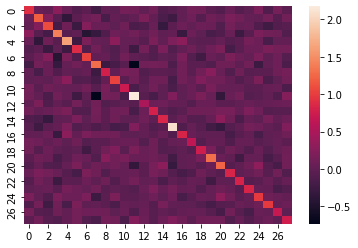

In [18]:
sb.heatmap(np.cov(X[0], rowvar=True))

In [19]:
for i in range(0, 60000, 10000):
    with open(f"./data/phy/train-EA_{i//10000}.pkl", mode="wb") as f:
        pkl.dump((X[i:i+10000], Y[i:i+10000], S[i:i+10000]), f)

In [ ]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
Xtest = list()
Ytest = list()

valid_subjects = set([f"PHY_{i}" for i in range(1, 31)])
test_subjects = set(["PHY_1"])

for subject in phy_ds_info["subject"].unique():
    Xsub = list()
    Ysub = list()
    is_training = list()
    for i, r in phy_ds_info[phy_ds_info["subject"] == subject].iterrows():
        x = phy_ds.datasets[i].windows.get_data()
        y = [label_map[r["label"]]] * len(x)
        Xsub.append(x)
        Ysub.extend(y)
        if r["trial"] in train_trials:
            is_training.extend([True] * len(x))
        else:
            is_training.extend([False] * len(x))

    Xsub = np.concatenate(Xsub, axis=0)
    Ysub = np.array(Ysub, dtype=int)
    is_training = np.array(is_training, dtype=bool)

    Xsub = np_euclidean_alignment(Xsub)

    if subject in test_subjects:
        Xtest.append(Xsub)
        Ytest.append(Ysub)
    elif subject in valid_subjects:
        train_idx = np.where(is_training)[0]
        Xtrain.append(Xsub[train_idx])
        Ytrain.append(Ysub[train_idx])
        valid_idx = np.where(~is_training)[0]
        if len(valid_idx) > 0:
            Xvalid.append(Xsub[valid_idx])
            Yvalid.append(Ysub[valid_idx])
    else:
        Xtrain.append(Xsub)
        Ytrain.append(Ysub)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.concatenate(Ytrain, axis=0)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.concatenate(Yvalid, axis=0)
Xtest = np.concatenate(Xtest, axis=0)
Ytest = np.concatenate(Ytest, axis=0)

print(Xtrain.shape, np.bincount(Ytrain))
print(Xvalid.shape, np.bincount(Yvalid))
print(Xtest.shape, np.bincount(Ytest))

(44565, 28, 256) [25470  6360  6420  6315]
(4560, 28, 256) [2610  645  663  642]
(477, 28, 256) [270  72  69  66]


In [ ]:
for i in range(0, 50000, 10000):
    with open(f"./data/train_EA_{i//10000}.pkl", mode="wb") as f:
        pkl.dump((Xtrain[i:i+10000], Ytrain[i:i+10000]), f)

with open("./data/valid_EA.pkl", mode="wb") as f:
    pkl.dump((Xvalid, Yvalid), f)

with open("./data/test_EA.pkl", mode="wb") as f:
    pkl.dump((Xtest, Ytest), f)

In [ ]:
target_subject = "PHY_1"  # @param

Xtrain_tgt = list()
Ytrain_tgt = list()

# compute label alignment transform matrices
for i, r in phy_ds_info[phy_ds_info["subject"] == target_subject].iterrows():
    x = phy_ds.datasets[i].windows.get_data()
    y = [label_map[r["label"]]] * len(x)
    Xtrain_tgt.append(x)
    Ytrain_tgt.extend(y)

Xtrain_tgt = np.concatenate(Xtrain_tgt, axis=0)
Ytrain_tgt = np.array(Ytrain_tgt, dtype=int)

Xtrain_tgt.shape, np.bincount(Ytrain_tgt)

((477, 28, 256), array([270,  72,  69,  66]))

In [ ]:
tgt_transform_mats = np_compute_target_transform_mats(Xtrain_tgt, Ytrain_tgt)

In [ ]:
Xtrain_src = list()
Ytrain_src = list()

for subject in phy_ds_info["subject"].unique():
    if subject == target_subject:
        continue

    Xsub = list()
    Ysub = list()
    for i, r in phy_ds_info[phy_ds_info["subject"] == subject].iterrows():
        x = phy_ds.datasets[i].windows.get_data()
        y = [label_map[r["label"]]] * len(x)
        Xsub.append(x)
        Ysub.extend(y)

    Xsub = np.concatenate(Xsub, axis=0)
    Ysub = np.array(Ysub, dtype=int)

    # Xsub = np_label_alignment(Xsub, Ysub, tgt_transform_mats)
    Xsub = np_euclidean_alignment(Xsub)

    Xtrain_src.append(Xsub)
    Ytrain_src.append(Ysub)

Xtrain_src = np.concatenate(Xtrain_src)
Ytrain_src = np.concatenate(Ytrain_src)

Xtrain_src.shape, np.bincount(Ytrain_src)

((49125, 28, 256), array([28080,  7005,  7083,  6957]))

In [ ]:
Xtrain_tgt = list()
Ytrain_tgt = list()

# compute label alignment transform matrices
for i, r in phy_ds_info[phy_ds_info["subject"] == target_subject].iterrows():
    x = phy_ds.datasets[i].windows.get_data()
    y = [label_map[r["label"]]] * len(x)
    Xtrain_tgt.append(x)
    Ytrain_tgt.extend(y)

Xtrain_tgt = np.concatenate(Xtrain_tgt, axis=0)
Ytrain_tgt = np.array(Ytrain_tgt, dtype=int)

Xtrain_tgt.shape, np.bincount(Ytrain_tgt)

((477, 28, 256), array([270,  72,  69,  66]))

In [ ]:
Xtrain_tgt = list()
Ytrain_tgt = list()
splitter_idx = list()

for i, r in phy_ds_info[phy_ds_info["subject"] == target_subject].iterrows():
    x = phy_ds.datasets[i].windows.get_data()
    y = [label_map[r["label"]]] * len(x)

    sidx = 0
    if r["trial"] in valid_trials:
        sidx = 1
    elif r["trial"] in test_trials:
        sidx = 2

    Xtrain_tgt.append(x)
    Ytrain_tgt.extend(y)
    splitter_idx.extend([sidx] * len(x))

Xtrain_tgt = np.concatenate(Xtrain_tgt, axis=0)
Ytrain_tgt = np.array(Ytrain_tgt, dtype=int)
splitter_idx = np.array(splitter_idx, dtype=int)

Xtrain_tgt = np_euclidean_alignment(Xtrain_tgt)

print(np.bincount(splitter_idx))
Xtrain_tgt.shape

[  0 159 318]


(477, 28, 256)

In [ ]:
idx = np.where(splitter_idx == 1)[0]
Xvalid_tgt = Xtrain_tgt[idx]
Yvalid_tgt = Ytrain_tgt[idx]
idx = np.where(splitter_idx == 2)[0]
Xtest_tgt = Xtrain_tgt[idx]
Ytest_tgt = Ytrain_tgt[idx]
idx = np.where(splitter_idx == 0)[0]
Xtrain_tgt = Xtrain_tgt[idx]
Ytrain_tgt = Ytrain_tgt[idx]

print(Xtrain_tgt.shape, np.bincount(Ytrain_tgt))
print(Xvalid_tgt.shape, np.bincount(Yvalid_tgt))
print(Xtest_tgt.shape, np.bincount(Ytest_tgt))

(0, 28, 256) []
(159, 28, 256) [90 24 24 21]
(318, 28, 256) [180  48  45  45]


In [ ]:
!rm -rf ./data/PHY_1_*

In [ ]:
for i in range(0, 50000, 10000):
    with open(f"./data/PHY_1_src_{i:06d}.pkl", mode="wb") as f:
        pkl.dump((Xtrain_src[i:i+10000], Ytrain_src[i:i+10000]), f)

with open("./data/PHY_1_tgt.pkl", mode="wb") as f:
    pkl.dump((Xtrain_tgt, Ytrain_tgt, Xvalid_tgt, Yvalid_tgt, Xtest_tgt, Ytest_tgt), f)

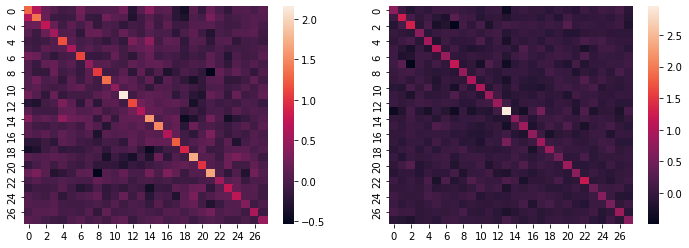

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

x = Xtrain_src[0]

x = x - x.mean(axis=1, keepdims=True)
x = (x @ x.T) / (x.shape[1] - 1)  # [C,C]

# diag = np.diagonal(x, axis1=1, axis2=0)[:, None]  # [C,1]
# x /= np.sqrt(diag @ diag.T)  # [C,C] \in [-1, 1]
# x /= 2.0
# x += 0.5

sb.heatmap(x, ax=axes[0])

x = Xtest_tgt[0]

x = x - x.mean(axis=1, keepdims=True)
x = (x @ x.T) / (x.shape[1] - 1)  # [C,C]

# diag = np.diagonal(x, axis1=1, axis2=0)[:, None]  # [C,1]
# x /= np.sqrt(diag @ diag.T)  # [C,C] \in [-1, 1]
# x /= 2.0
# x += 0.5

sb.heatmap(x, ax=axes[1])

#### load physionet data

In [ ]:
Xtrain_src = list()
Ytrain_src = list()
for i in range(0, 50000, 10000):
    with open(f"./data/PHY_1_src_{i:06d}.pkl", mode="rb") as f:
        x, y = pkl.load(f)
        Xtrain_src.append(x)
        Ytrain_src.append(y)

Xtrain_src = np.concatenate(Xtrain_src, axis=0)
Ytrain_src = np.concatenate(Ytrain_src, axis=0)

Xtrain_src.shape, np.bincount(Ytrain_src)

((49125, 28, 256), array([28080,  7005,  7083,  6957]))

In [ ]:
with open("./data/PHY_1_tgt.pkl", mode="rb") as f:
    Xtrain_tgt, Ytrain_tgt, Xvalid_tgt, Yvalid_tgt, Xtest_tgt, Ytest_tgt = pkl.load(f)

print(Xtrain_tgt.shape, np.bincount(Ytrain_tgt))
print(Xvalid_tgt.shape, np.bincount(Yvalid_tgt))
print(Xtest_tgt.shape, np.bincount(Ytest_tgt))

(0, 28, 256) []
(159, 28, 256) [90 24 24 21]
(318, 28, 256) [180  48  45  45]


In [ ]:
Xunlabeled_tgt = np.concatenate((Xvalid_tgt, Xtest_tgt), axis=0)
Yunlabeled_tgt = np.concatenate((Yvalid_tgt, Ytest_tgt), axis=0)

Xunlabeled_tgt.shape, np.bincount(Yunlabeled_tgt)

((477, 28, 256), array([270,  72,  69,  66]))

In [ ]:
Xtrain = list()
Ytrain = list()
for i in range(5):
    with open(f"./data/train_{i}.pkl", mode="rb") as f:
        x, y = pkl.load(f)
    Xtrain.append(x)
    Ytrain.append(y)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.concatenate(Ytrain, axis=0)

with open("./data/valid.pkl", mode="rb") as f:
    Xvalid, Yvalid = pkl.load(f)

with open("./data/test.pkl", mode="rb") as f:
    Xtest, Ytest = pkl.load(f)

print(Xtrain.shape, np.bincount(Ytrain))
print(Xvalid.shape, np.bincount(Yvalid))
print(Xtest.shape, np.bincount(Ytest))

(44565, 28, 256) [25470  6360  6420  6315]
(4560, 28, 256) [2610  645  663  642]
(477, 28, 256) [270  72  69  66]


#### gen VINIF data

In [ ]:
with open("./data/vin/5classes-EA.pkl", mode="rb") as f:
    exp_ds = pkl.load(f)
    
ds_info = exp_ds.description
ds_info

subject        scenario     event           label  trial  split
0       K001   nâng tay trái  Thinking   nâng tay trái      0  train
1       K001   nâng tay trái   Resting            rest      0  train
2       K001   nâng tay trái   Resting            rest      1  train
3       K001   nâng tay trái  Thinking   nâng tay trái      1  train
4       K001   nâng tay trái  Thinking   nâng tay trái      2  train
...      ...             ...       ...             ...    ...    ...
2444    K375  nâng chân phải   Resting            rest      0  train
2445    K375  nâng chân phải  Thinking  nâng chân phải      1  train
2446    K375  nâng chân phải   Resting            rest      1  train
2447    K375  nâng chân phải  Thinking  nâng chân phải      2  train
2448    K375  nâng chân phải   Resting            rest      2  train

[2449 rows x 6 columns]

In [ ]:
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

# target_subject = "K309"  # @param

# exp_ds = deepcopy(ds)
# label_alignment(exp_ds, target_subject=target_subject, labeled_trials={
#     "rest": [0],
#     "nâng tay trái": [0],
#     "nâng tay phải": [0],
# })
# euclidean_alignment(exp_ds, target_subject=None, labeled_trials=None)

In [ ]:
valid_trials_map = {
    "rest": [4, 5],
    "nâng tay trái": [2],
    "nâng tay phải": [2],
    "nâng chân trái": [2],
    "nâng chân phải": [2],
    "gật đầu": [2],
    "lắc đầu": [2],
}

test_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    'K313', 'K314', 'K315', 'K316', 'K319', 
    # 'K320', 'K321', 'K322', 'K323', 'K324', 
    # 'K325', 'K326', 'K327', 'K328', 'K329', 
    # 'K330', 'K331', 'K332', 'K333', 'K334', 
    # 'K335', 'K336', 'K337', 'K338', 'K339', 
    # 'K340', 'K342', 'K343', 'K344', 'K350', 
    # 'K351', 'K352', 'K353', 'K354', 'K355', 
    # 'K356', 'K357', 'K358', 'K359', 'K360', 
    # 'K361', 'K362', 'K363', 'K364', 'K365', 
    # 'K366', 'K367', 'K368', 'K369', 'K370', 
    # 'K371', 'K372', 'K373', 'K374', 'K375',
}
test_subject_data = defaultdict(list)

list_of_train_ds = list()
list_of_valid_ds = list()
# list_of_test_ds = list()
for _ds in exp_ds.datasets:
    _ds_info = _ds.description
    # if _ds_info["subject"] == target_subject:
    if _ds_info["subject"] in test_subjects:
        test_subject_data[_ds_info["subject"]].append(_ds)
    #     list_of_test_ds.append(_ds)
    # elif _ds_info["subject"] in valid_subjects and _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
    elif _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
        list_of_valid_ds.append(_ds)
    else:
        list_of_train_ds.append(_ds)
        
train_ds = BaseConcatDataset(list_of_train_ds)
valid_ds = BaseConcatDataset(list_of_valid_ds)
# test_ds = BaseConcatDataset(list_of_test_ds)

print(len(train_ds))
print(len(valid_ds))
# print(len(test_ds))

list_of_test_ds = list()
for k, v in test_subject_data.items():
    kds = BaseConcatDataset(v)
    print(f"{k}: {len(kds)}")
    list_of_test_ds.append((k, kds))

27730
11694
K300: 712
K309: 647
K310: 738
K311: 717
K312: 740
K313: 729
K314: 659
K315: 762
K316: 755
K319: 711


In [ ]:
train_trials_map = {
    "rest": [0],
    "nâng tay trái": [0],
    "nâng tay phải": [0],
}
valid_trials_map = {
    "rest": [1, 2],
    "nâng tay trái": [1],
    "nâng tay phải": [1],
}
test_trials_map = {
    "rest": [3, 4],
    "nâng tay trái": [2],
    "nâng tay phải": [2],
}

list_of_train_src_ds = list()
list_of_train_tgt_ds = list()
list_of_valid_tgt_ds = list()
list_of_test_tgt_ds = list()
for _ds in exp_ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"] == target_subject:
        if _ds_info["trial"] in train_trials_map[_ds_info["label"]]:
            list_of_train_tgt_ds.append(_ds)
        elif _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
            list_of_valid_tgt_ds.append(_ds)
        else:
            list_of_test_tgt_ds.append(_ds)
    else:
        list_of_train_src_ds.append(_ds)

train_src_ds = BaseConcatDataset(list_of_train_src_ds)
train_tgt_ds = BaseConcatDataset(list_of_train_tgt_ds)
valid_tgt_ds = BaseConcatDataset(list_of_valid_tgt_ds)
test_tgt_ds = BaseConcatDataset(list_of_test_tgt_ds)
unlabeled_tgt_ds = BaseConcatDataset(list_of_valid_tgt_ds + list_of_test_tgt_ds)

In [ ]:
print(len(train_src_ds))
print(len(train_tgt_ds))
print(len(valid_tgt_ds))
print(len(test_tgt_ds))
print(len(unlabeled_tgt_ds))

23444
111
175
111
286


#### load physionet & VINIF data

In [23]:
Xsrc = list()
Ysrc = list()
Ssrc = list()
for i in range(4):
    with open(f"./data/phy/train-EA_{i}.pkl", mode="rb") as f:
        x, y, s = pkl.load(f)
    Xsrc.append(x)
    Ysrc.append(y)
    Ssrc.append(s)

Xsrc = np.concatenate(Xsrc, axis=0)
Ysrc = np.concatenate(Ysrc, axis=0)
Ssrc = np.concatenate(Ssrc, axis=0)

print(Xsrc.shape, np.bincount(Ysrc))

(40000, 28, 256) [20001  4974  5016  5061  4948]


In [25]:
with open("./data/vin/LRF0_4classes_32c_action-EA.pkl", mode="rb") as f:
    exp_ds = pkl.load(f)
    
ds_info = exp_ds.description
ds_info

subject        scenario                event          label  trial  split
0       K001   nâng tay trái             Thinking  nâng tay trái      0  train
1       K001   nâng tay trái              Resting           rest      0  train
2       K001   nâng tay trái  Thinking and Acting  nâng tay trái      0  train
3       K001   nâng tay trái              Resting           rest      1  train
4       K001   nâng tay trái             Thinking  nâng tay trái      1  train
...      ...             ...                  ...            ...    ...    ...
3703    K375  nâng chân phải              Resting           rest      3  train
3704    K375  nâng chân phải             Thinking      nâng chân      2  train
3705    K375  nâng chân phải              Resting           rest      4  train
3706    K375  nâng chân phải  Thinking and Acting      nâng chân      2  train
3707    K375  nâng chân phải              Resting           rest      5  train

[3708 rows x 6 columns]

In [26]:
print(exp_ds.datasets[0].windows.info["ch_names"])

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT9', 'FC5', 'FC1', 'FC2', 'FC6', 'FT10', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']


In [27]:
ds_info["label"].unique()

array(['nâng tay trái', 'rest', 'nâng chân', 'nâng tay phải'],
      dtype=object)

In [28]:
ds_info[(ds_info["subject"] == "K300")]

subject        scenario                event          label  trial  split
664    K300   nâng tay trái             Thinking  nâng tay trái      0  train
665    K300   nâng tay trái              Resting           rest      0  train
666    K300   nâng tay trái  Thinking and Acting  nâng tay trái      0  train
667    K300   nâng tay trái              Resting           rest      1  train
668    K300   nâng tay trái             Thinking  nâng tay trái      1  train
669    K300   nâng tay trái              Resting           rest      2  train
670    K300   nâng tay trái  Thinking and Acting  nâng tay trái      1  train
671    K300   nâng tay trái              Resting           rest      3  train
672    K300   nâng tay trái             Thinking  nâng tay trái      2  train
673    K300   nâng tay trái              Resting           rest      4  train
674    K300   nâng tay trái  Thinking and Acting  nâng tay trái      2  train
675    K300   nâng tay phải             Thinking  nâng tay phải      0  train
676    K300   nâng tay phải              Resting           rest      0  train
677    K300   nâng tay phải  Thinking and Acting  nâng tay phải      0  train
678    K300   nâng tay phải              Resting           rest      1  train
679    K300   nâng tay phải             Thinking  nâng tay phải      1  train
680    K300   nâng tay phải              Resting           rest      2  train
681    K300   nâng tay phải  Thinking and Acting  nâng tay phải      1  train
682    K300   nâng tay phải              Resting           rest      3  train
683    K300   nâng tay phải             Thinking  nâng tay phải      2  train
684    K300   nâng tay phải              Resting           rest      4  train
685    K300   nâng tay phải  Thinking and Acting  nâng tay phải      2  train
686    K300   nâng tay phải              Resting           rest      5  train
687    K300  nâng chân trái             Thinking      nâng chân      0  train
688    K300  nâng chân trái              Resting           rest      0  train
689    K300  nâng chân trái  Thinking and Acting      nâng chân      0  train
690    K300  nâng chân trái              Resting           rest      1  train
691    K300  nâng chân trái             Thinking      nâng chân      1  train
692    K300  nâng chân trái              Resting           rest      2  train
693    K300  nâng chân trái  Thinking and Acting      nâng chân      1  train
694    K300  nâng chân trái              Resting           rest      3  train
695    K300  nâng chân trái             Thinking      nâng chân      2  train
696    K300  nâng chân trái              Resting           rest      4  train
697    K300  nâng chân trái  Thinking and Acting      nâng chân      2  train
698    K300  nâng chân trái              Resting           rest      5  train
699    K300  nâng chân phải             Thinking      nâng chân      0  train
700    K300  nâng chân phải              Resting           rest      0  train
701    K300  nâng chân phải  Thinking and Acting      nâng chân      0  train
702    K300  nâng chân phải              Resting           rest      1  train
703    K300  nâng chân phải             Thinking      nâng chân      1  train
704    K300  nâng chân phải              Resting           rest      2  train
705    K300  nâng chân phải  Thinking and Acting      nâng chân      1  train
706    K300  nâng chân phải              Resting           rest      3  train
707    K300  nâng chân phải             Thinking      nâng chân      2  train
708    K300  nâng chân phải              Resting           rest      4  train
709    K300  nâng chân phải  Thinking and Acting      nâng chân      2  train
710    K300  nâng chân phải              Resting           rest      5  train

In [29]:
len(ds_info["subject"].unique())

96

In [30]:
valid_trials_map = {
    "rest": [4, 5],
    "nâng tay trái": [2],
    "nâng tay phải": [2],
    "nâng chân trái": [2],
    "nâng chân phải": [2],
    "nâng chân": [2],
    "gật đầu": [2],
    "lắc đầu": [2],
}
# train_trials_map = {
#     "rest": [0, 1],
#     "nâng tay trái": [0, 1],
#     "nâng tay phải": [0, 1],
#     "nâng chân trái": [0, 1],
#     "nâng chân phải": [0, 1],
#     "nâng chân": [0, 1],
#     "gật đầu": [0, 1],
#     "lắc đầu": [0, 1],
# }
# valid_trials_map = {
#     "rest": [2],
#     "nâng tay trái": [2],
#     "nâng tay phải": [2],
#     "nâng chân trái": [2],
#     "nâng chân phải": [2],
#     "nâng chân": [2],
#     "gật đầu": [2],
#     "lắc đầu": [2],
# }

test_subjects = {
    # "ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2",
    'K300', 'K309', 'K310', 
    # 'K311', 'K312', 'K313', 
    # 'K314', 'K315', 'K316', 
    # 'K319', 'K320', 'K321', 
    # 'K322', 'K323', 'K324', 
    # 'K325', 'K326', 'K327', 
    # 'K328', 'K329', 'K330', 
    # 'K331', 'K332', 'K333', 
    # 'K334', 'K335', 'K336', 
    # 'K337', 'K338', 'K339', 
    # 'K340', 'K342', 'K343', 
    # 'K344', 'K350', 'K351', 
    # 'K352', 'K353', 'K354', 
    # 'K355', 'K356', 'K357', 
    # 'K358', 'K359', 'K360', 
    # 'K361', 'K362', 'K363', 
    # 'K364', 'K365', 'K366', 
    # 'K367', 'K368', 'K369', 
    # 'K370', 'K371', 'K372', 
    # 'K373', 'K374', 'K375',
}

# transfer_subject = "ALS01_t1"
# target_subject = "ALS01_t2"

test_subject_data = defaultdict(list)

list_of_train_ds = list()
list_of_valid_ds = list()
# list_of_test_ds = list()
for _ds in exp_ds.datasets:
    _ds_info = _ds.description
    # if _ds_info["subject"] == target_subject:
    if _ds_info["subject"] in test_subjects:
        test_subject_data[_ds_info["subject"]].append(_ds)
    #     list_of_test_ds.append(_ds)
    # elif _ds_info["subject"] == transfer_subject and _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
    elif _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
    # elif _ds_info["subject"] in test_subjects:
    # if _ds_info["subject"] == target_subject:
        list_of_valid_ds.append(_ds)
    else:
        list_of_train_ds.append(_ds)
    # if _ds_info["subject"] == target_subject:
    #     # if _ds_info["trial"] in train_trials_map[_ds_info["label"]]:
    #     #     list_of_valid_ds.append(_ds)
    #     if _ds_info["trial"] in valid_trials_map[_ds_info["label"]]:
    #         list_of_valid_ds.append(_ds)
    #     elif _ds_info["trial"] in train_trials_map[_ds_info["label"]]:
    #         list_of_train_ds.append(_ds)
    #     else:
    #         test_subject_data[_ds_info["subject"]].append(_ds)
    # else:
    #     list_of_train_ds.append(_ds)
        
train_ds = BaseConcatDataset(list_of_train_ds)
valid_ds = BaseConcatDataset(list_of_valid_ds)
# test_ds = BaseConcatDataset(list_of_test_ds)

# label_alignment(train_ds, target_subject=transfer_subject, labeled_trials=train_trials_map)
# euclidean_alignment(train_ds, target_subject=None, labeled_trials=None)
# euclidean_alignment(valid_ds, target_subject=None, labeled_trials=None)

print(len(train_ds))
print(len(valid_ds))
# print(len(test_ds))

list_of_test_ds = list()
for k, v in test_subject_data.items():
    kds = BaseConcatDataset(v)
    # euclidean_alignment(kds, target_subject=None, labeled_trials=None)
    
    print(f"{k}: {len(kds)}")
    list_of_test_ds.append((k, kds))

23082
10329
K300: 487
K309: 467
K310: 471


In [31]:
del exp_ds
del ds_info

#### training module

In [33]:
%%time
# exp = f"baseline/{target_subject}"  # @param
exp = "MI_ME-32c-LRF0"
# exp = "MI-17c-ALS01_t2-LA-EA"
n_classes = 4  # @param
n_channels = 32  # @param
n_samples = 256  # @param
top_k = 4  # @param
use_augmentation = False  # @param {"type": "boolean"}
use_normalization = True  # @param {"type": "boolean"}
epochs = 50  # @param
batch_size = 64  # @param
lr = 1e-3  # @param
use_lr_sch = True  # @param {"type": "boolean"}
weight_decay = 0.01  # @param
smooth_label = 0.1  # @param
after_n_epochs = 30  # @param
mixup_alpha = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = False  # @param {"type": "boolean"}
use_subject_sampler = False  # @param {"type": "boolean"}
drop_prob = 0.25  # @param
monitor_val = "acc"  # @param
monitor_max_is_best = True  # @param {"type": "boolean"}
patience_epochs = 10  # @param

do_training(
    exp=exp,
    n_classes=n_classes,
    n_channels=n_channels,
    n_samples=n_samples,
    # train_data=(Xtrain, Ytrain), 
    # valid_data=(Xvalid, Yvalid), 
    # test_data=(Xtest, Ytest),
    train_data=train_ds,
    valid_data=valid_ds,
    # test_data=test_ds,
    test_data=list_of_test_ds,
    top_k=top_k,
    use_augmentation=use_augmentation,
    use_normalization=use_normalization,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    use_lr_sch=use_lr_sch,
    weight_decay=weight_decay,
    smooth_label=smooth_label,
    after_n_epochs=after_n_epochs,
    mixup_alpha=mixup_alpha,
    use_class_weight=use_class_weight,
    use_imbalanced_sampler=use_imbalanced_sampler,
    use_subject_sampler=use_subject_sampler,
    drop_prob=drop_prob,
    monitor_val=monitor_val,
    monitor_max_is_best=monitor_max_is_best,
    patience_epochs=patience_epochs,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | base_model | MB_EEGNet     | 6.0 K 
1 | clf        | EEGClassifier | 260   
---------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


"after_n_epochs": 30
"class_weight":   tensor([0.5814, 0.9045, 2.1661, 1.4033], device='cuda:0')
"drop_prob":      0.25
"epochs":         50
"lr":             0.001
"mixup_alpha":    0.0
"n_channels":     32
"n_classes":      4
"n_samples":      256
"rng_seed":       42
"smooth_label":   0.1
"use_lr_sch":     True
"weight_decay":   0.01
MotorImageryModule(
  (base_model): MB_EEGNet(
    (conv_1s): ModuleList(
      (0): ConvTS(
        (conv_temporal): WSConv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
        (bnorm_temporal): TemporalNorm(
          (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
        )
        (conv_spatial): WSConv2d(8, 32, kernel_size=(32, 1), stride=(1, 1), groups=8, bias=False)
        (bnorm_1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (elu_1): Mish()
        (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
        (drop_1): Dropout(p=0.25, inplace=False)
      )
    )
    (conv_2): Sequential(
      (

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

training MI_ME-32c-LRF0 done - time: 0:10:22.927999s
MI_ME-32c-LRF0 validation:
{'acc': 0.5184304007245968, 'f1': 0.5662570064556913, 'kappa': 0.3959189235585575}
MI_ME-32c-LRF0 validation confusion_matrix:
[[2935  217  303  345]
 [ 664 1533  633  407]
 [ 249  331  555  220]
 [ 361  304  462  810]]
testing on K300...
MI_ME-32c-LRF0 test:
{'acc': 0.4727111400840215, 'f1': 0.5409924360026949, 'kappa': 0.32921631089093206}
MI_ME-32c-LRF0 test confusion_matrix:
[[123  17  39  57]
 [  4  59  17  37]
 [  2  12  14  28]
 [  4   7  19  48]]
testing on K309...
MI_ME-32c-LRF0 test:
{'acc': 0.4351798515104967, 'f1': 0.5166460108503049, 'kappa': 0.301318443515315}
MI_ME-32c-LRF0 test confusion_matrix:
[[141  20  17  38]
 [ 27  67  18  12]
 [ 13  47   3   0]
 [ 16   9   7  32]]
testing on K310...
MI_ME-32c-LRF0 test:
{'acc': 0.38812686724757867, 'f1': 0.533373161558377, 'kappa': 0.27789242164504957}
MI_ME-32c-LRF0 test confusion_matrix:
[[158  27  22  38]
 [  6  49  27  31]
 [  5  17   9  24]
 [ 13

In [26]:
%%time
exp = "multidatasets"  # @param
n_classes = 5  # @param
n_channels = 28  # @param
n_samples = 256  # @param
n_src_classes = 5  # @param
top_k = 4  # @param
use_augmentation = False  # @param {"type": "boolean"}
use_normalization = True  # @param {"type": "boolean"}
epochs = 40  # @param
batch_size = 64  # @param
lr = 1e-3  # @param
use_lr_sch = True  # @param {"type": "boolean"}
weight_decay = 1e-2  # @param
smooth_label = 0.1  # @param
src_loss_scale = 1.0  # @param
tgt_loss_scale = 0.3  # @param
src_loss_scale_after_n = 0.3  # @param
tgt_loss_scale_after_n = 1.0  # @param
after_n_epochs = 16  # @param
src_mixup_alpha = 0.0  # @param
tgt_mixup_alpha = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = False  # @param {"type": "boolean"}
use_subject_sampler = False  # @param {"type": "boolean"}
drop_prob = 0.25  # @param
monitor_val = "acc"  # @param
monitor_max_is_best = True  # @param {"type": "boolean"}
patience_epochs = 10  # @param

do_md_training(
    exp=exp,
    n_classes=n_classes,
    n_channels=n_channels,
    n_samples=n_samples,
    n_src_classes=n_src_classes,
    train_src_data=(Xsrc, Ysrc, Ssrc),
    train_tgt_data=train_ds,
    valid_tgt_data=valid_ds,
    # test_tgt_data=test_ds,
    test_tgt_data=list_of_test_ds,
    top_k=top_k,
    use_augmentation=use_augmentation,
    use_normalization=use_normalization,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    use_lr_sch=use_lr_sch,
    weight_decay=weight_decay,
    smooth_label=smooth_label,
    src_loss_scale=src_loss_scale,
    tgt_loss_scale=tgt_loss_scale,
    src_loss_scale_after_n=src_loss_scale_after_n,
    tgt_loss_scale_after_n=tgt_loss_scale_after_n,
    after_n_epochs=after_n_epochs,
    src_mixup_alpha=src_mixup_alpha,
    tgt_mixup_alpha=tgt_mixup_alpha,
    use_class_weight=use_class_weight,
    use_imbalanced_sampler=use_imbalanced_sampler,
    use_subject_sampler=use_subject_sampler,
    drop_prob=drop_prob,
    monitor_val=monitor_val,
    monitor_max_is_best=monitor_max_is_best,
    patience_epochs=patience_epochs,
)

/home/txdat/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:58: LightningDeprecationWarning: Setting `Trainer(stochastic_weight_avg=True)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.stochastic_weight_avg.StochasticWeightAveraging` directly to the Trainer's `callbacks` argument instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


"after_n_epochs":         16
"drop_prob":              0.25
"epochs":                 40
"lr":                     0.001
"n_channels":             28
"n_classes":              5
"n_samples":              256
"n_src_classes":          5
"rng_seed":               42
"smooth_label":           0.1
"src_class_weight":       tensor([0.4000, 1.6084, 1.5949, 1.5807, 1.6168], device='cuda:0')
"src_loss_scale":         1.0
"src_loss_scale_after_n": 0.3
"src_mixup_alpha":        0.0
"tgt_class_weight":       tensor([0.3298, 2.4445, 1.7339, 2.4280, 1.7546], device='cuda:0')
"tgt_loss_scale":         0.3
"tgt_loss_scale_after_n": 1.0
"tgt_mixup_alpha":        0.0
"use_lr_sch":             True
"weight_decay":           0.01
MultiDatasetsMotorImageryModule(
  (base_model): MB_EEGNet(
    (conv_1s): ModuleList(
      (0): ConvTS(
        (conv_temporal): WSConv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
        (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, a

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | base_model | MB_EEGNet     | 5.5 K 
1 | clf        | EEGClassifier | 325   
2 | src_clf    | EEGClassifier | 325   
---------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Swapping scheduler `MultiStepLR` for `SWALR`


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

training MD/multidatasets done - time: 0:19:29.498584s
MD/multidatasets validation:
{'acc': 0.5008425331585893, 'f1': 0.6588862240205289, 'kappa': 0.48073308028694073}
MD/multidatasets validation confusion_matrix:
[[3155   87   99   79  307]
 [  26  294  195  124   61]
 [  51  218  386  159  138]
 [  45   84  172  269  122]
 [  65   43  202  212  416]]
testing on K300...
MD/multidatasets test:
{'acc': 0.4258615819209039, 'f1': 0.6314300938216078, 'kappa': 0.3580579562785968}
MD/multidatasets test confusion_matrix:
[[179   0   2   5  50]
 [  0   9   7   8   0]
 [  3   6  13   0   8]
 [  9   1  15   0   3]
 [ 17   2   1   1  27]]
testing on K309...
MD/multidatasets test:
{'acc': 0.4697062579821202, 'f1': 0.6464841260544625, 'kappa': 0.3916156860533957}
MD/multidatasets test confusion_matrix:
[[156   5  11   1  43]
 [  1   8  13   7   1]
 [  0   5  22   0   0]
 [  0   4  17   6   3]
 [  2   1   2  14  10]]
testing on K310...
MD/multidatasets test:
{'acc': 0.34468818612488983, 'f1': 0.4949

In [ ]:
%%time
# exp = ""  # @param
exp = target_subject
n_classes = 3  # @param
n_channels = 28  # @param
n_samples = 256  # @param
top_k = 4  # @param
use_augmentation = False  # @param {"type": "boolean"}
use_normalization = True  # @param {"type": "boolean"}
mcd_step_C_steps = 10  # @param
epochs = 30  # @param
batch_size = 64  # @param
lr = 1e-3  # @param
use_lr_sch = False  # @param {"type": "boolean"}
weight_decay = 0.0  # @param
smooth_label = 0.1  # @param
src_loss_scale = 1.0  # @param
tgt_loss_scale = 0.5  # @param
src_loss_scale_after_n = 0.5  # @param
tgt_loss_scale_after_n = 1.0  # @param
after_n_epochs = 10  # @param
src_mixup_alpha = 0.0  # @param
tgt_mixup_alpha = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = False  # @param {"type": "boolean"}
drop_prob = 0.25  # @param
monitor_val = "acc"  # @param
monitor_max_is_best = True  # @param {"type": "boolean"}
patience_epochs = 10  # @param

do_mcd_training(
    exp=exp,
    n_classes=n_classes,
    n_channels=n_channels,
    n_samples=n_samples,
    train_src_data=train_ds, 
    valid_tgt_data=valid_ds, 
    unlabeled_tgt_data=test_ds,
    test_tgt_data=test_ds,
    # train_src_data=(Xtrain, Ytrain), 
    # valid_tgt_data=(Xvalid, Yvalid), 
    # unlabeled_tgt_data=(Xtest, Ytest),
    # test_tgt_data=(Xtest, Ytest),
    # train_src_data=(Xtrain_src, Ytrain_src), 
    # train_tgt_data=(Xtrain_tgt, Ytrain_tgt), 
    # valid_tgt_data=(Xvalid_tgt, Yvalid_tgt), 
    # unlabeled_tgt_data=(Xunlabeled_tgt, Yunlabeled_tgt),
    # test_tgt_data=(Xtest_tgt, Ytest_tgt),
    # train_src_data=train_src_ds,
    # train_tgt_data=train_tgt_ds,
    # valid_tgt_data=valid_tgt_ds,
    # unlabeled_tgt_data=unlabeled_tgt_ds,
    # test_tgt_data=test_tgt_ds,
    top_k=top_k,
    use_augmentation=use_augmentation,
    use_normalization=use_normalization,
    mcd_step_C_steps=mcd_step_C_steps,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    use_lr_sch=use_lr_sch,
    weight_decay=weight_decay,
    smooth_label=smooth_label,
    src_loss_scale=src_loss_scale,
    tgt_loss_scale=tgt_loss_scale,
    src_loss_scale_after_n=src_loss_scale_after_n,
    tgt_loss_scale_after_n=tgt_loss_scale_after_n,
    after_n_epochs=after_n_epochs,
    src_mixup_alpha=src_mixup_alpha,
    tgt_mixup_alpha=tgt_mixup_alpha,
    use_class_weight=use_class_weight,
    use_imbalanced_sampler=use_imbalanced_sampler,
    drop_prob=drop_prob,
    monitor_val=monitor_val,
    monitor_max_is_best=monitor_max_is_best,
    patience_epochs=patience_epochs,
)

In [ ]:
%%time
exp = "multidatasets"  # @param
# exp = target_subject
n_classes = 5  # @param
n_channels = 28  # @param
n_samples = 256  # @param
n_src_classes = 5  # @param
top_k = 4  # @param
use_augmentation = False  # @param {"type": "boolean"}
use_normalization = True  # @param {"type": "boolean"}
mcd_step_C_steps = 5  # @param
epochs = 20  # @param
batch_size = 64  # @param
lr = 1e-3  # @param
use_lr_sch = True  # @param {"type": "boolean"}
weight_decay = 1e-2  # @param
smooth_label = 0.1  # @param
src_loss_scale = 1.0  # @param
tgt_loss_scale = 0.3  # @param
src_loss_scale_after_n = 0.3  # @param
tgt_loss_scale_after_n = 1.0  # @param
after_n_epochs = 8  # @param
src_mixup_alpha = 0.0  # @param
tgt_mixup_alpha = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = False  # @param {"type": "boolean"}
use_subject_sampler = True  # @param {"type": "boolean"}
drop_prob = 0.25  # @param
monitor_val = "acc"  # @param
monitor_max_is_best = True  # @param {"type": "boolean"}
patience_epochs = 10  # @param

list_of_unlabeled_ds = list()
# list_of_unlabeled_ds.extend(valid_ds.datasets)
for _, test_ds in list_of_test_ds:
    list_of_unlabeled_ds.extend(test_ds.datasets)

unlabeled_ds = BaseConcatDataset(list_of_unlabeled_ds)

do_md_mcd_training(
    exp=exp,
    n_classes=n_classes,
    n_channels=n_channels,
    n_samples=n_samples,
    n_src_classes=n_src_classes,
    train_src_data=(Xsrc, Ysrc, Ssrc), 
    train_tgt_data=train_ds, 
    valid_tgt_data=valid_ds, 
    unlabeled_tgt_data=unlabeled_ds,
    test_tgt_data=list_of_test_ds,
    top_k=top_k,
    use_augmentation=use_augmentation,
    use_normalization=use_normalization,
    mcd_step_C_steps=mcd_step_C_steps,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    use_lr_sch=use_lr_sch,
    weight_decay=weight_decay,
    smooth_label=smooth_label,
    src_loss_scale=src_loss_scale,
    tgt_loss_scale=tgt_loss_scale,
    src_loss_scale_after_n=src_loss_scale_after_n,
    tgt_loss_scale_after_n=tgt_loss_scale_after_n,
    after_n_epochs=after_n_epochs,
    src_mixup_alpha=src_mixup_alpha,
    tgt_mixup_alpha=tgt_mixup_alpha,
    use_class_weight=use_class_weight,
    use_imbalanced_sampler=use_imbalanced_sampler,
    use_subject_sampler=use_subject_sampler,
    drop_prob=drop_prob,
    monitor_val=monitor_val,
    monitor_max_is_best=monitor_max_is_best,
    patience_epochs=patience_epochs,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


"after_n_epochs":         8
"drop_prob":              0.25
"epochs":                 20
"lr":                     0.001
"mcd_step_C_steps":       5
"n_channels":             28
"n_classes":              5
"n_samples":              256
"n_src_classes":          5
"rng_seed":               42
"smooth_label":           0.1
"src_class_weight":       tensor([0.4000, 1.6084, 1.5949, 1.5807, 1.6168], device='cuda:0')
"src_loss_scale":         1.0
"src_loss_scale_after_n": 0.3
"src_mixup_alpha":        0.0
"tgt_class_weight":       tensor([0.3290, 2.4155, 1.7665, 2.4104, 1.7683], device='cuda:0')
"tgt_loss_scale":         0.3
"tgt_loss_scale_after_n": 1.0
"tgt_mixup_alpha":        0.0
"use_lr_sch":             True
"weight_decay":           0.01
MultiDatasetsMCDMotorImageryModule(
  (base_model): MB_EEGNet(
    (conv_1s): ModuleList(
      (0): ConvTS(
        (conv_temporal): WSConv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
        (bnorm_temporal): BCNorm(
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params
---------------------------------------------
0 | base_model | MB_EEGNet     | 5.6 K 
1 | clf1       | EEGClassifier | 325   
2 | clf2       | EEGClassifier | 325   
3 | src_clf    | EEGClassifier | 325   
---------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/txdat/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# PHY_1-EA validation:
# {'acc': 0.44061238323946006, 'f1': 0.4881920148589359, 'kappa': 0.23390696741289352}
# PHY_1-EA validation confusion_matrix:
# [[1263  572  332  443]
#  [ 145  250   86  164]
#  [ 104  149  253  157]
#  [  95  133   87  327]]
# PHY_1-EA test:
# {'acc': 0.4009268408724931, 'f1': 0.4229364190292441, 'kappa': 0.17958402042661847}
# PHY_1-EA test confusion_matrix:
# [[101  89  29  51]
#  [ 10  31  15  16]
#  [ 11   6  29  23]
#  [  4  22  15  25]]

# PHY_1 validation:
# {'acc': 0.3932938640658058, 'f1': 0.3886584823409278, 'kappa': 0.15577668713729398}
# PHY_1-EA validation confusion_matrix:
# [[862 582 346 820]
#  [108 209  96 232]
#  [ 92 128 192 251]
#  [ 67  97  74 404]]
# PHY_1-EA test:
# {'acc': 0.4281025838091056, 'f1': 0.4269235364568036, 'kappa': 0.20224817314079935}
# PHY_1-EA test confusion_matrix:
# [[97 46 73 54]
#  [ 6 25 30 11]
#  [ 7  2 37 23]
#  [ 5 11 19 31]]

# MCD/PHY_1-EA validation:
# {'acc': 0.4514804627491238, 'f1': 0.5036479330743322, 'kappa': 0.25395520342825817}
# MCD/PHY_1-EA validation confusion_matrix:
# [[1360  291  457  502]
#  [ 142  145  139  219]
#  [ 125   46  330  162]
#  [  97   46  138  361]]
# MCD/PHY_1-EA test:
# {'acc': 0.49592391304347827, 'f1': 0.4986710894948685, 'kappa': 0.2791915762096556}
# MCD/PHY_1-EA test confusion_matrix:
# [[120  64  34  52]
#  [  5  31  29   7]
#  [  8   1  42  18]
#  [  9   5  19  33]]

# MCD/PHY_1 validation:
# {'acc': 0.38909483086910784, 'f1': 0.4558941985287379, 'kappa': 0.18123942164714058}
# MCD/PHY_1-EA validation confusion_matrix:
# [[1304  161  546  599]
#  [ 196   87  174  188]
#  [ 166   32  289  176]
#  [ 132   43  155  312]]
# MCD/PHY_1 test:
# {'acc': 0.38769488361879667, 'f1': 0.4141009968119698, 'kappa': 0.15871491474441446}
# MCD/PHY_1-EA test confusion_matrix:
# [[105  49  65  51]
#  [ 15  21  26  10]
#  [ 14   0  36  19]
#  [ 11   3  29  23]]

In [ ]:
# PHY_1-EA-MCD validation:
# {'acc': 0.44691630860815135, 'f1': 0.523282218837789, 'kappa': 0.2602947856796324}
# PHY_1-EA-MCD validation confusion_matrix:
# [[1505  435  293  377]
#  [ 163  203  106  173]
#  [ 151   97  239  176]
#  [ 143   84   71  344]]
# PHY_1-EA-MCD test:
# {'acc': 0.4276643244034548, 'f1': 0.3937438427158093, 'kappa': 0.18979515575636108}
# PHY_1-EA-MCD test confusion_matrix:
# [[80 83 34 73]
#  [ 4 24 22 22]
#  [ 4  4 38 23]
#  [ 2 10 19 35]]

# PHY_1-EA-MCD validation:
# {'acc': 0.45125740701107286, 'f1': 0.5272430130567776, 'kappa': 0.26725443399236803}
# PHY_1-EA-MCD validation confusion_matrix:
# [[1504  327  401  378]
#  [ 155  201  129  160]
#  [ 148   87  290  138]
#  [ 123   75  136  308]]
# PHY_1-EA-MCD test:
# {'acc': 0.47806415605328645, 'f1': 0.4598542601897231, 'kappa': 0.25011790598962436}
# PHY_1-EA-MCD test confusion_matrix:
# [[100  99  26  45]
#  [  2  43  11  16]
#  [  4   5  38  22]
#  [  7  14  19  26]]

# PHY_1-EA-MCD validation:
# {'acc': 0.4565619401864984, 'f1': 0.532004524625284, 'kappa': 0.2761062516231976}
# PHY_1-EA-MCD validation confusion_matrix:
# [[1553  184  409  464]
#  [ 185  137  140  183]
#  [ 149   38  313  163]
#  [ 119   39  133  351]]
# PHY_1-EA-MCD test:
# {'acc': 0.3934929000146391, 'f1': 0.42146499032052726, 'kappa': 0.1741739052565595}
# PHY_1-EA-MCD test confusion_matrix:
# [[106  78  38  48]
#  [ 12  16  30  14]
#  [  8   1  39  21]
#  [  9   6  25  26]]

# PHY_1-EA-MCD validation:
# {'acc': 0.4575056453367258, 'f1': 0.5153007630210196, 'kappa': 0.2636831533887558}
# PHY_1-EA-MCD validation confusion_matrix:
# [[1420  319  440  431]
#  [ 154  152  141  198]
#  [ 143   64  338  118]
#  [ 102   62  131  347]]
# PHY_1-EA-MCD test:
# {'acc': 0.46513321622017273, 'f1': 0.4299917388084218, 'kappa': 0.21787308533916838}
# PHY_1-EA-MCD test confusion_matrix:
# [[ 91 105  30  44]
#  [ 10  32  17  13]
#  [  8   3  41  17]
#  [  6   8  20  32]]

# PHY_1-EA-MCD validation:
# {'acc': 0.4573422959109794, 'f1': 0.4785221932849442, 'kappa': 0.24162278058513786}
# PHY_1-EA-MCD validation confusion_matrix:
# [[1183  267  548  612]
#  [ 106  158  140  241]
#  [ 110   35  341  177]
#  [  83   43  120  396]]
# PHY_1-EA-MCD test:
# {'acc': 0.49021373151807934, 'f1': 0.41116932930362754, 'kappa': 0.22948553877655486}
# PHY_1-EA-MCD test confusion_matrix:
# [[ 77 102  34  57]
#  [  3  44  16   9]
#  [  8   0  40  21]
#  [  5   9  20  32]]

In [ ]:
# PHY_1-LA-EA-MCD validation:
# {'acc': 0.639781746031746, 'f1': 0.5468033754382257, 'kappa': 0.38272403752830797}
# PHY_1-LA-EA-MCD validation confusion_matrix:
# [[38 10 26 16]
#  [ 6 11  2  5]
#  [ 0  0 22  2]
#  [ 2  0  3 16]]
# PHY_1-LA-EA-MCD test:
# {'acc': 0.5666666666666667, 'f1': 0.5272506420936317, 'kappa': 0.3296578563320902}
# PHY_1-LA-EA-MCD test confusion_matrix:
# [[39 26 18  7]
#  [ 5 16  3  0]
#  [ 3  1 14  3]
#  [ 0  1 11 12]]

# PHY_1-LA-EA-MCD validation:
# {'acc': 0.725, 'f1': 0.5863739990144327, 'kappa': 0.45352288704889854}
# PHY_1-LA-EA-MCD validation confusion_matrix:
# [[36 14 11 29]
#  [ 0 20  1  3]
#  [ 1  0 16  7]
#  [ 0  0  0 21]]
# PHY_1-LA-EA-MCD test:
# {'acc': 0.6742063492063491, 'f1': 0.5709739961589915, 'kappa': 0.41271880520314763}
# PHY_1-LA-EA-MCD test confusion_matrix:
# [[37 35  3 15]
#  [ 2 21  1  0]
#  [ 2  2 13  4]
#  [ 2  2  1 19]]

# PHY_1-LA-EA-MCD validation:
# {'acc': 0.752281746031746, 'f1': 0.6322155774529431, 'kappa': 0.5022285896211398}
# PHY_1-LA-EA-MCD validation confusion_matrix:
# [[41 12 25 12]
#  [ 0 21  3  0]
#  [ 0  1 22  1]
#  [ 0  0  5 16]]
# PHY_1-LA-EA-MCD test:
# {'acc': 0.7115079365079364, 'f1': 0.6206038128576921, 'kappa': 0.47138652714192275}
# PHY_1-LA-EA-MCD test confusion_matrix:
# [[44 22 15  9]
#  [ 1 20  1  2]
#  [ 2  0 18  1]
#  [ 2  1  5 16]]

# PHY_1-LA-EA-MCD validation:
# {'acc': 0.7648809523809523, 'f1': 0.659467456945215, 'kappa': 0.5282408156659654}
# PHY_1-LA-EA-MCD validation confusion_matrix:
# [[45  9 19 17]
#  [ 0 22  2  0]
#  [ 1  1 20  2]
#  [ 0  0  4 17]]
# PHY_1-LA-EA-MCD test:
# {'acc': 0.787797619047619, 'f1': 0.7295971063401531, 'kappa': 0.6005481329222336}
# PHY_1-LA-EA-MCD test confusion_matrix:
# [[57 18  5 10]
#  [ 0 23  1  0]
#  [ 2  1 17  1]
#  [ 2  2  2 18]]

# PHY_1-LA-EA-MCD validation:
# {'acc': 0.8156746031746032, 'f1': 0.759923865888044, 'kappa': 0.6367997258865855}
# PHY_1-LA-EA-MCD validation confusion_matrix:
# [[59  7 18  6]
#  [ 0 20  4  0]
#  [ 2  0 22  0]
#  [ 0  0  3 18]]
# PHY_1-LA-EA-MCD test:
# {'acc': 0.7238095238095238, 'f1': 0.6918997010293418, 'kappa': 0.5393707630801321}
# PHY_1-LA-EA-MCD test confusion_matrix:
# [[57 15  8 10]
#  [ 1 21  1  1]
#  [ 3  0 16  2]
#  [ 4  2  3 15]]

In [29]:
module = MotorImageryModule(
    n_classes=5,
    n_channels=32,
    n_samples=256,
)

ckpt_dir = f"./ckpt/K309/b17e1395737b432f9fc5ff361f552b19"
module.load_state_dict(torch.load(f"{ckpt_dir}/best.ckpt", map_location=device)["state_dict"])
module.to(device)
module.eval()

MotorImageryModule(
  (base_model): MB_EEGNet(
    (conv_1s): ModuleList(
      (0): ConvTS(
        (conv_temporal): WSConv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
        (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (conv_spatial): WSConv2d(8, 32, kernel_size=(32, 1), stride=(1, 1), groups=8, bias=False)
        (bnorm_1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (elu_1): ELU(alpha=1.0, inplace=True)
        (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
        (drop_1): Dropout(p=0.0, inplace=False)
      )
    )
    (conv_2): Sequential(
      (conv_separable_depth): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=32, bias=False)
      (conv_separable_point): WSConv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bnorm_2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, trac

<AxesSubplot:>

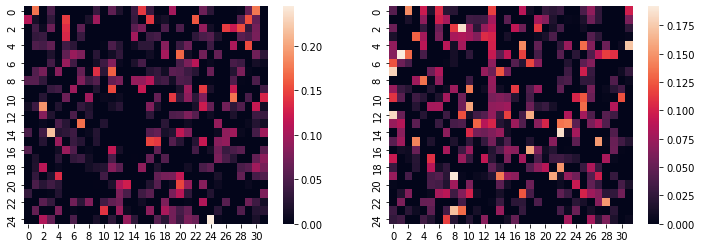

In [29]:
w = module.base_model.conv_1s[0].conv_spatial.weight.detach().cpu().numpy().reshape((32, 25)).T
wp = w * (w > 0)
wn = np.abs(w * (w < 0))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sb.heatmap(wp, ax=axes[0])
sb.heatmap(wn, ax=axes[1])

<AxesSubplot:>

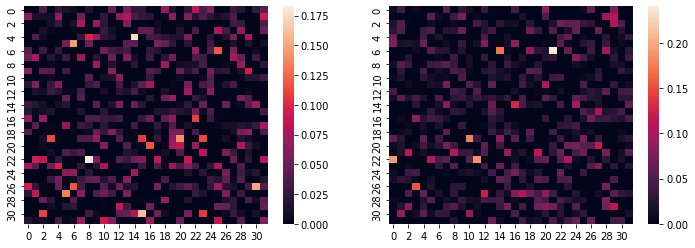

In [30]:
w = module.base_model.conv_1s[0].conv_spatial.weight.detach().cpu().numpy().reshape((32, 32)).T
wp = w * (w > 0)
wn = np.abs(w * (w < 0))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sb.heatmap(wp, ax=axes[0])
sb.heatmap(wn, ax=axes[1])

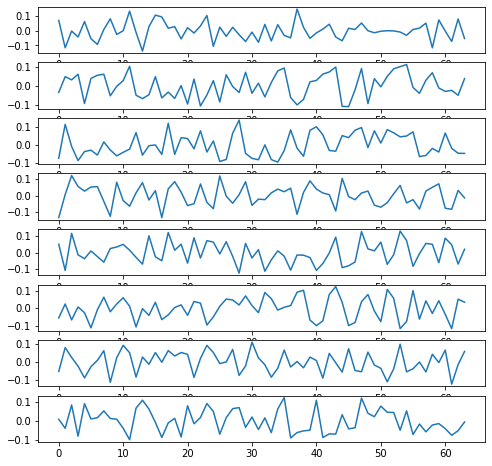

In [31]:
w = module.base_model.conv_1s[0].conv_temporal.weight.detach().cpu().numpy().reshape((8, 64))

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8, 8))

for i in range(8):
    axes[i].plot(range(64), w[i])

## visualize

In [ ]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.manifold import TSNE

In [ ]:
Ctrain = np.stack([np.cov(xi, rowvar=True) for xi in Xtrain])
Cvalid = np.stack([np.cov(xi, rowvar=True) for xi in Xvalid])
Ctrain.shape, Cvalid.shape

In [ ]:
ts = TangentSpace(metric="riemann")

feat = ts.fit_transform(np.concatenate([Ctrain, Cvalid], axis=0))

In [ ]:
y = np.concatenate([Ytrain, Yvalid], axis=0)

In [ ]:
tsne = TSNE()

feat2d = tsne.fit_transform(feat)

In [ ]:
for yi in np.unique(y):
    idx = np.where(y == yi)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])

In [ ]:
for yi in np.unique(y):
    idx = np.where(y == yi)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])

In [ ]:
for yi in np.unique(y):
    idx = np.where(y == yi)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])

In [ ]:
for yi in np.unique(y):
    idx = np.where(y == yi)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])

In [ ]:
for yi in np.unique(y):
    idx = np.where(y == yi)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1])